In [1]:
from HeaderP import *

In [2]:
def log_prior(params):
    m = params[0]
    return -1.5 * np.log(1 + m*m)

def log_marg_prob_scatter(params, S, yn, xn):
    m, b, log_lambda = params
    v = np.array([-m, 1.0])

    # Enforce the log-uniform prior on lambda. 
    if not -5.0 < log_lambda < 5.0:
        return -np.inf

    # Compute \Sigma^2 and \Delta.
    lamd = np.exp(log_lambda)
    Lambda = np.zeros((2,2))
    Lambda[0,0], Lambda[0,1], Lambda[1,0], Lambda[1,1] =  m**2, -m, -m, 1
    Lambda = Lambda * lamd**2/(1+m**2)
    Sigma2 = np.dot(np.dot(S+Lambda, v), v)
    Delta = m * xn + b - yn

    # Compute the log likelihood up to a constant.
    ll = -0.5 * np.sum(Delta**2 / Sigma2 + np.log(Sigma2))
    return ll + log_prior(params)

import emcee

def monoage(feh,r,age,agebin=np.linspace(0,14,8),xlims=[6,12],ylims=[-1.5,0.5]):
    colors = getcolor(range(len(agebin)+1))
    plt.figure(figsize=(20,8))
    for i in range(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        r_sing = r_sing[m2]
        feh_sing = feh_sing[m2]
        
        r_ave, feh_ave = movingMed_time(r_sing, feh_sing, 1, 0.1)
        #feh_ave = gaussian_filter(feh_ave, 4)
        """if agebin[i]==12.:
            plt.plot(r_sing, feh_sing,'.', color=colors[i], markersize=1)"""
        plt.plot(r_ave, feh_ave, color=colors[i], 
                 label='[%.2f Gyr, %.2f Gyr]'%(agebin[i],agebin[i+1]))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=3)
    plt.grid(color='grey', linestyle='-', linewidth=1)
    plt.xlabel('R [kpc]')
    plt.ylabel('[Fe/H]')
    plt.xlim(xlims)
    plt.ylim(ylims)

def getscatt_bay(feh, r, age, feh_err, r_err, agebin=np.linspace(0,14,8),
             rbin=10, xlims=[6,12],ylims=[-1.5,0.5],feherr=[]):
    
    nwalkers=64
    rbins = np.linspace(xlims[0], xlims[1], rbin)
    scatters = np.zeros((len(agebin)-1, rbin-1))
    scatters_err = np.zeros((len(agebin)-1, rbin-1))
    
    m = (r>xlims[0])&(r<xlims[1])
    feh, r, age = feh[m], r[m], age[m]
    feherr = feh_err[m]
    rerr = r_err[m]
    
    for i in trange(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, feh_sing = r[m], feh[m]
        feh_err_sing = feherr[m]
        r_err_sing = rerr[m]
        
        for j in range(rbin-1):
            m = (r_sing>rbins[j])&(r_sing<rbins[j+1])
            if sum(m)<10:
                #print(agebin[i], rbins[j], sum(m))
                scatters[i,j] = np.nan
            else:
                r_sing_2, feh_sing_2 = r_sing[m], feh_sing[m]
                feh_err_sing_2 = feh_err_sing[m]
                r_err_sing_2 = r_err_sing[m]
        
                S = np.zeros((len(feh_sing_2),2,2))
                for k in range(len(feh_sing_2)):
                    S[k,0,0] = r_err_sing_2[k]**2
                    S[k,1,1] = feh_err_sing_2[k]**2
                print(agebin[i], rbins[j], len(feh_sing_2))
                z = np.polyfit(r_err_sing_2,feh_sing_2,1)
                sampler_scatter = emcee.EnsembleSampler(nwalkers, 3, log_marg_prob_scatter, args=(S, feh_sing_2, r_sing_2))
                p0 = np.array([z[0], z[1], np.log(0.03)])
                p0 = p0 + 1e-4 * np.random.randn(nwalkers, len(p0))
                pos, _, _ = sampler_scatter.run_mcmc(p0, 1000, progress=True)
                sampler_scatter.reset()
                sampler_scatter.run_mcmc(pos, 6000, progress=True)
                samples_scatter = sampler_scatter.flatchain

                """# m
                mcmc = np.percentile(samples_scatter[:, 0], [16, 50, 84])
                q = np.diff(mcmc)
                hi_m[i,0], hi_m[i,1], hi_m[i,2] = mcmc[1], q[0], q[1]

                # b
                mcmc = np.percentile(samples_scatter[:, 1], [16, 50, 84])
                q = np.diff(mcmc)
                hi_b[i,0], hi_b[i,1], hi_b[i,2] = mcmc[1], q[0], q[1]"""

                # dispersion
                mcmc = np.percentile(samples_scatter[:, 2], [16, 50, 84])
                q = np.diff(mcmc)
                scatters[i,j], dishi, dislow = mcmc[1], q[0], q[1]
                scatters_err[i,j] = np.mean(abs(dishi)+abs(dislow))

                
    return (agebin[:-1]+agebin[1:])/2, (rbins[:-1]+rbins[1:])/2, scatters, scatters_err


def getscatt(feh, r, age, agebin=np.linspace(0,14,8),
             rbin=10, xlims=[6,12],ylims=[-1.5,0.5],feherr=[]):
    rbins = np.linspace(xlims[0], xlims[1], rbin)
    scatters = np.zeros((len(agebin)-1, rbin-1))
    
    m = (r>xlims[0])&(r<xlims[1])
    feh, r, age = feh[m], r[m], age[m]
    if len(feherr)>0:
            feherr = feherr[m]
    
    for i in range(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, feh_sing = r[m], feh[m]
        if len(feherr)>0:
            feh_err_sing = feherr[m]
        for j in range(rbin-1):
            m = (r_sing>rbins[j])&(r_sing<rbins[j+1])
            if sum(m)<10:
                scatters[i,j] = np.nan
            else:
                r_sing_2, feh_sing_2 = r_sing[m], feh_sing[m]
                p = fitpoints(r_sing_2, feh_sing_2) 
                scatters[i,j] = np.std(feh_sing_2-p(r_sing_2))

                if len(feherr)>0:
                    feh_err_sing_2 = feh_err_sing[m]
                    scatters[i,j] = np.sqrt(scatters[i,j]**2-np.mean(feh_err_sing_2)**2)

    return (agebin[:-1]+agebin[1:])/2, (rbins[:-1]+rbins[1:])/2, scatters
    
def monoage_line(feh,r,age,agebin=np.linspace(0,14,8),xlims=[6,12],ylims=[-1.5,0.5],
                feherr=[],plotlegend=True):
    colors = getcolor(range(len(agebin)+1))
    slopes = np.zeros(len(agebin)-1)
    fehscatter = np.zeros(len(agebin)-1)
    
    plt.figure(figsize=(20,8))
    for i in trange(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        if sum(m)==0:
            fehscatter[i] = np.nan
            continue
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        if sum(m2)==0:
            fehscatter[i] = np.nan
            continue
        p = fitpoints(r_sing[m2], feh_sing[m2]) 
        slopes[i] = p[1]
        fehscatter[i] = np.std(feh_sing[m2]-p(r_sing[m2]))
        if len(feherr)>0:
            fehscatter[i] = np.sqrt(fehscatter[i]**2-np.mean(feherr[m][m2])**2)
            #print(np.std(feh_sing[m2]-p(r_sing[m2])))
        plt.plot(r_sing[m2], p(r_sing[m2]), color=colors[i], 
                 label='[%.2f Gyr, %.2f Gyr]'%(agebin[i],agebin[i+1]))
    if plotlegend:
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=3)
    plt.xlabel('R [kpc]')
    plt.ylabel('[Fe/H]')
    plt.xlim(xlims)
    plt.ylim(ylims)
    #plt.savefig(i+'.png')
    return (agebin[:-1]+agebin[1:])/2, slopes, fehscatter
    
def getcolor(vrange, cmap=plt.cm.get_cmap('plasma')):
    norm = matplotlib.colors.Normalize(vmin=min(vrange), vmax=max(vrange))
    #print([cmap(norm(i)) for i in vrange])
    return [cmap(norm(i)) for i in vrange]


def avr(age, r, vz, rbin=np.linspace(6,12,4), agebin=np.linspace(0,14,10)):
    colors = getcolor(range(len(rbin)+1))
    avrs = np.zeros((len(rbin)-1, len(agebin)-1))
    for i in trange(len(rbin)-1):
        m = (r>rbin[i])&(r<rbin[i+1])
        age_r, r_r, vz_r = age[m], r[m], vz[m]
        for j in range(len(agebin)-1):
            m2 = (age_r>agebin[j])&(age_r<agebin[j+1])
            if sum(m2)<10:
                avrs[i,j]=np.nan
            else:
                vz_r_age = vz_r[m2]
                avrs[i,j] = 1.5*sum(abs(vz_r_age-np.median(vz_r_age)))/sum(m2)
    return (agebin[:-1]+agebin[1:])/2, (rbin[:-1]+rbin[1:])/2, avrs
    

# Check simiulation with a bar

In [3]:
pd.read_pickle('../NIHAORbirth/g2.79e12_z_0_decomp.pkl').columns

Index(['z', 'metals', 'rxy', 'y', 'mass', 'eps', 'x', 'phi', 'j_circ', 'ke',
       'te', 'decomp', 'j_x', 'j_y', 'tform', 'iord', 'j_z', 'vy', 'vz',
       'vcxy', 'jz_by_jzcirc', 'vx', 'ofe', 'feh', 'age', 'Rbir', 'zbir', 'R',
       'dR', 'dz', 'vc', 'Rg'],
      dtype='object')

In [4]:
#simNo='6_96e11'
simNo='2_79e12'
#simNo='7_55e11'
#z='0'
#z='0_097' 
#z='0_255'
z='0'
# app-center passage
#z='0_25' 
#z='0_2' 
#z='0_195' 
#z='0_19' 
#z='0_1' 
# peri-center passage
#z='0_34' 
#z='0_35' 
#z='0_36' 
Rcut=True
select=False
Rcut_thread=30
zcut_thread=5

In [5]:


if simNo=='data':
    data=pd.read_pickle('../SecondYear/CannonDR16_cut.pkl')
    data['z_today']=data['z']
    data['x_today']=data['X']
    data['y_today']=data['Y']
    data['feh_scale']=data['M_H']
    data['ofe_scale']=data['O_FE']
    data['age']=data['Age']
elif select:
    data=pd.read_pickle('Data/Buck_g'+simNo+'_apogee_selec.pkl')
    data['R_bir']=np.sqrt((data['x_birth'])**2+data['y_birth']**2)
    data['R']=np.sqrt((data['x_today'])**2+data['y_today']**2)
    scale_fe=0.250019907951355/np.std(data['feh'])
    scale_o=0.10861970484256744/np.std(data['ofe'])
    data['feh_scale']=data['feh']*scale_fe-0.0906638577580452-np.mean(data['feh'])
    data['ofe_scale']=data['ofe']*scale_o+0.08182460814714432-np.mean(data['ofe'])
elif not select:
    if z=='0':
        data=pd.read_pickle('../SimulationData/Data/Buck_g'+simNo+'.pkl')
        #rg = pd.read_pickle('../NIHAORbirth/g'+simNo.split('_')[0]+'.'+simNo.split('_')[1]+'_z_0_decomp.pkl')
        #data = pd.merge(data, rg[['iord','Rg']], left_on='iord', right_on='iord',
        #               how='inner')
    else:
        data=pd.read_pickle('../SimulationData/Data/Buck_g'+simNo+'_z'+z+'.pkl')
        try:
            data['x_today']=data['x']
            data['y_today']=data['y']
            data['z_today']=data['z']
        except:
            print(np.shape(data['x_today']))
        
    data['R_bir']=np.sqrt((data['x_birth'])**2+data['y_birth']**2)
    data['R']=np.sqrt((data['x_today'])**2+data['y_today']**2)
    scale_fe=0.250019907951355/np.std(data['feh'])
    scale_o=0.10861970484256744/np.std(data['ofe'])
    data['feh_scale']=data['feh']*scale_fe-0.0906638577580452-np.mean(data['feh'])
    data['ofe_scale']=data['ofe']*scale_o+0.08182460814714432-np.mean(data['ofe'])
    
        
vscale = 240/340
rscale = 3.5/5.6
data['vx'] = data['vx']*vscale
data['vy'] = data['vy']*vscale
data['vz'] = data['vz']*vscale

data['vx_birth'] = data['vx_birth']*vscale
data['vy_birth'] = data['vy_birth']*vscale
data['vz_birth'] = data['vz_birth']*vscale

data['R'] = data['R']*rscale
#data['Rg'] = data['Rg']*rscale
data['R_bir'] = data['R_bir']*rscale
data['x'] = data['x']*rscale
data['y'] = data['y']*rscale
data['z'] = data['z']*rscale

data['x_birth'] = data['x_birth']*rscale
data['y_birth'] = data['y_birth']*rscale
data['z_birth'] = data['z_birth']*rscale

data['Jr'] = data['Jz']*rscale*rscale
data['Jphi'] = data['Jphi']*rscale*rscale
data['Jz'] = data['Jz']*rscale*rscale

if Rcut:
    data=data.loc[data['R_bir']<Rcut_thread].reset_index(drop=True)
    data=data.loc[abs(data['z_birth'])<zcut_thread].reset_index(drop=True)
        
data.columns

Index(['vx_birth', 'vy_today', 'vz_today', 'z_today', 'vy_birth', 'ofe',
       'iords', 'vx_today', 'x_today', 'feh', 'x_birth', 'y_birth', 'vz_birth',
       'mass', 'y_today', 'oxh', 'z_birth', 'age', 'iord', 'vx', 'vy', 'vz',
       'x', 'y', 'z', 'Jr', 'Jphi', 'Jz', 'R', 'R_bir', 'feh_scale',
       'ofe_scale'],
      dtype='object')

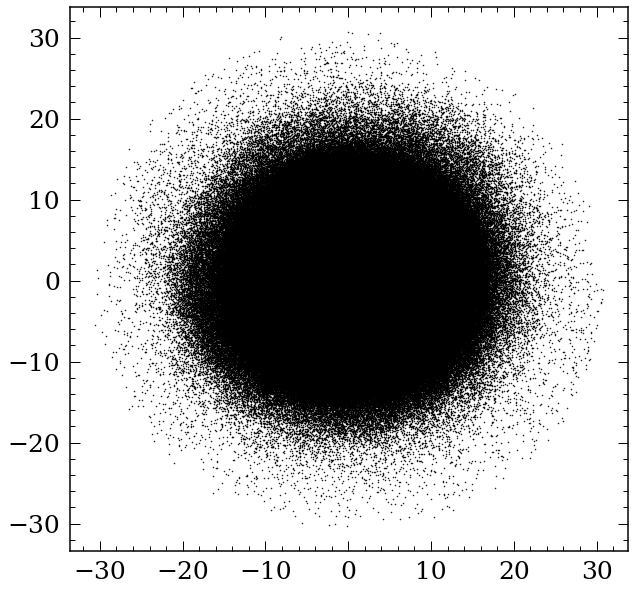

In [6]:
plt.plot(data['x'], data['y'], 'k.', markersize=1)

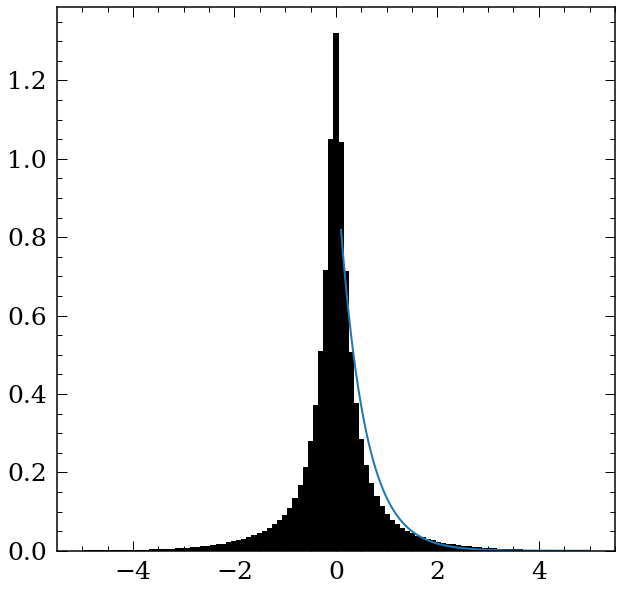

In [7]:
plt.hist(data['z'], bins=np.linspace(-5,5,100), color='k', density=1);
plt.plot(np.linspace(0.1,5,100), np.exp(-np.linspace(0.1,5,100)/0.5))

Text(0, 0.5, '[α/Fe]')

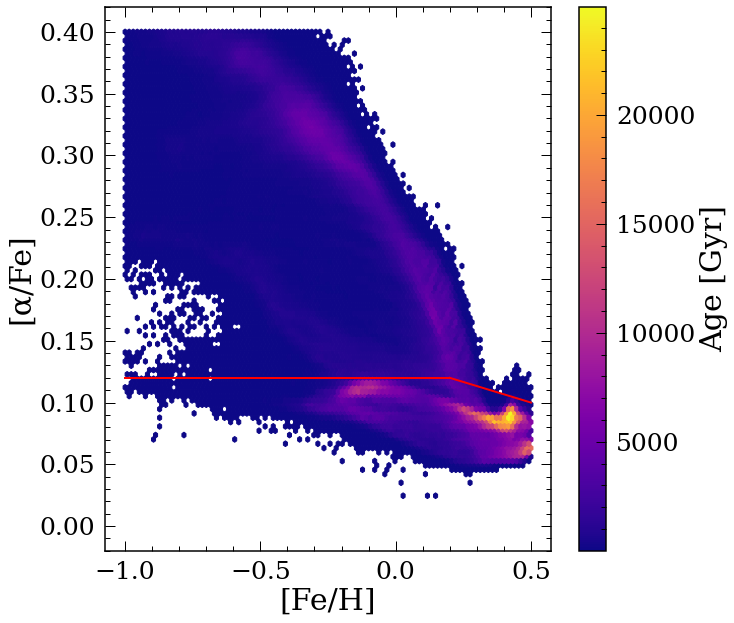

In [8]:
plt.hexbin(data['feh'], data['ofe'], extent=(-1,0.5,0,0.4), cmap='plasma',
          mincnt=1)

plt.plot([-1,0.2], [0.12,0.12], 'r-')
plt.plot([0.2,0.5], [0.12,0.1], 'r-')

def hilow_disk(feh, alpha):
    hi_low = np.zeros(len(feh))
    
    m = feh<0.2
    hi_low[m] = alpha[m]>0.12
    
    p = fitpoints([0.2,0.5], [0.12,0.1])
    hi_low[~m] = alpha[~m]>p(feh[~m])
    
    return hi_low

data['hi_low'] = hilow_disk(data['feh'].values, data['ofe'].values)
#sub_low = data.loc[data['hi_low']==1]
#plt.plot(sub_low['feh'], sub_low['ofe'], 'r.')

cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.xlabel('[Fe/H]')
plt.ylabel('[α/Fe]')



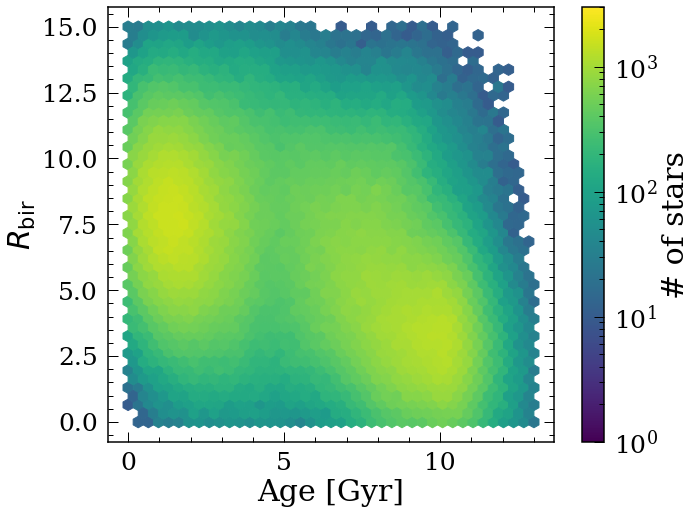

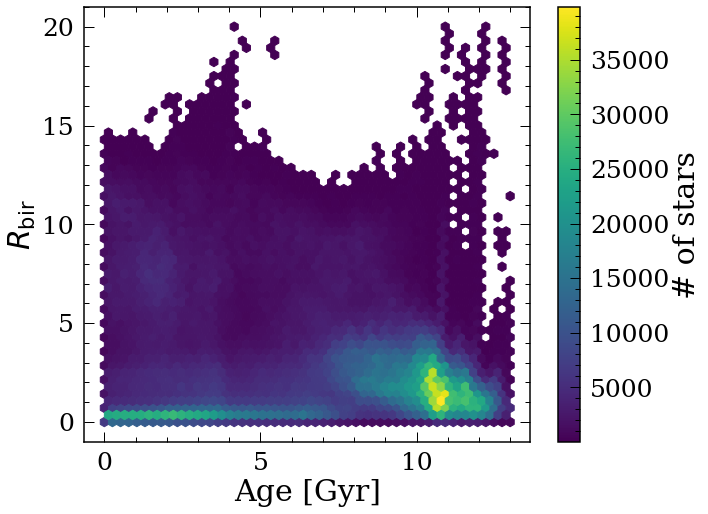

In [9]:
import warnings
warnings.filterwarnings('ignore')

data['age_new'] = [np.random.normal(i, 0.5) for i in data['age']]
data['rbir_new'] = [np.random.normal(i, 2) for i in data['R_bir']]
data['feh_new'] = [np.random.normal(i, 0.03) for i in data['feh']]

plt.figure(figsize=(10,8))
m = (data['R']>7)&(data['R']<10)
plt.hexbin(data['age_new'][m], data['rbir_new'][m],
          extent=(0,13,0,15), mincnt=10, gridsize=40,
          vmin=1, vmax=3000, bins='log')
plt.xlabel('Age [Gyr]')
plt.ylabel('$R_{\mathrm{bir}}$')
plt.colorbar(label='# of stars')
plt.savefig('Rb_279e12_SN.png')
plt.savefig('Rb_279e12_SN')



plt.figure(figsize=(10,8))
plt.hexbin(data['age'], data['R_bir'],
          extent=(0,13,0,20), mincnt=10, gridsize=50,
          vmin=1)
plt.xlabel('Age [Gyr]')
plt.ylabel('$R_{\mathrm{bir}}$')
plt.colorbar(label='# of stars')
plt.savefig('Rb_279e12.png')
plt.savefig('Rb_279e12')

In [10]:
#data[['age','R_bir','feh','R']].to_csv('279e12.csv', index=False)

100%|██████████| 29/29 [00:03<00:00,  9.34it/s]


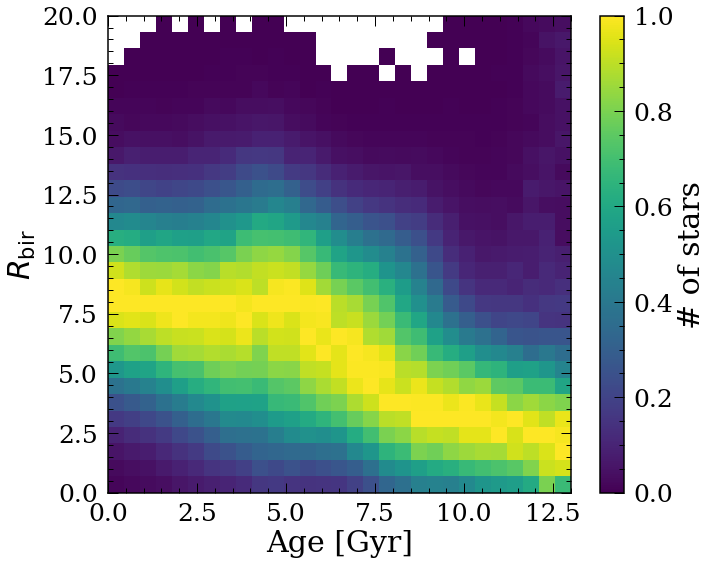

In [11]:
def coldensity(x,y,binsize=50,extend=[]):
    if len(extend)==0:
        extend=(min(x),max(x),min(y),max(y))
    H, yedges, xedges = np.histogram2d(x, y, 
                                bins=(np.linspace(extend[0],extend[1],binsize),
                                        np.linspace(extend[2],extend[3],binsize)))
    for i in trange(len(yedges)-1):
        m = (x>yedges[i])&(x<yedges[i+1])
        H[i,:] = (H[i,:]/sum(m))/max(H[i,:]/sum(m))
    """for i in trange(len(xedges)-1):
        m = (y>xedges[i])&(y<xedges[i+1])
        H[:,i] = (H[:,i]/sum(m))/max(H[:,i]/sum(m))"""
    
    for i in range(len(H[0,:])):
        for j in range(len(H[:,0])):
            if H[j,i] == 0:
                H[j,i] = np.nan

    return yedges, xedges, H.T


"""plt.figure(figsize=(20,8))
plt.subplot(1,2,1)

yedges, xedges, H = coldensity(data['age_new'], data['rbir_new'],binsize=30,
          extend=(0,13,0,20))

plt.pcolormesh(yedges, xedges, H, vmin=0, vmax=1)
plt.xlabel('Age [Gyr]')
plt.ylabel('$R_{\mathrm{bir}}$')
plt.colorbar(label='# of stars')


plt.subplot(1,2,2)"""

plt.figure(figsize=(10,8))
m = (data['R']>7)&(data['R']<10)
yedges, xedges, H = coldensity(data['age_new'][m], data['rbir_new'][m],binsize=30,
          extend=(0,13,0,20))

plt.pcolormesh(yedges, xedges, H, vmin=0, vmax=1)
plt.xlabel('Age [Gyr]')
plt.ylabel('$R_{\mathrm{bir}}$')
plt.colorbar(label='# of stars')
plt.tight_layout()

plt.savefig('Rb_279e12_norm.png')
plt.savefig('Rb_279e12_norm')

100%|██████████| 29/29 [00:03<00:00,  9.38it/s]


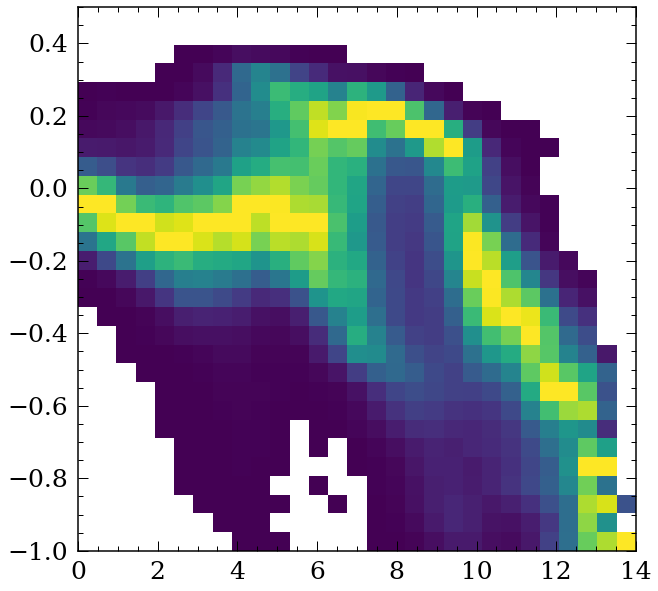

In [12]:
"""plt.hexbin(data['age_new'][m], data['feh'][m],
          extent=(0,14,-1,0.5))"""

yedges, xedges, H = coldensity(data['age_new'][m], data['feh'][m],binsize=30,
          extend=(0,14,-1,0.5))

plt.pcolormesh(yedges, xedges, H, vmin=0, vmax=1)


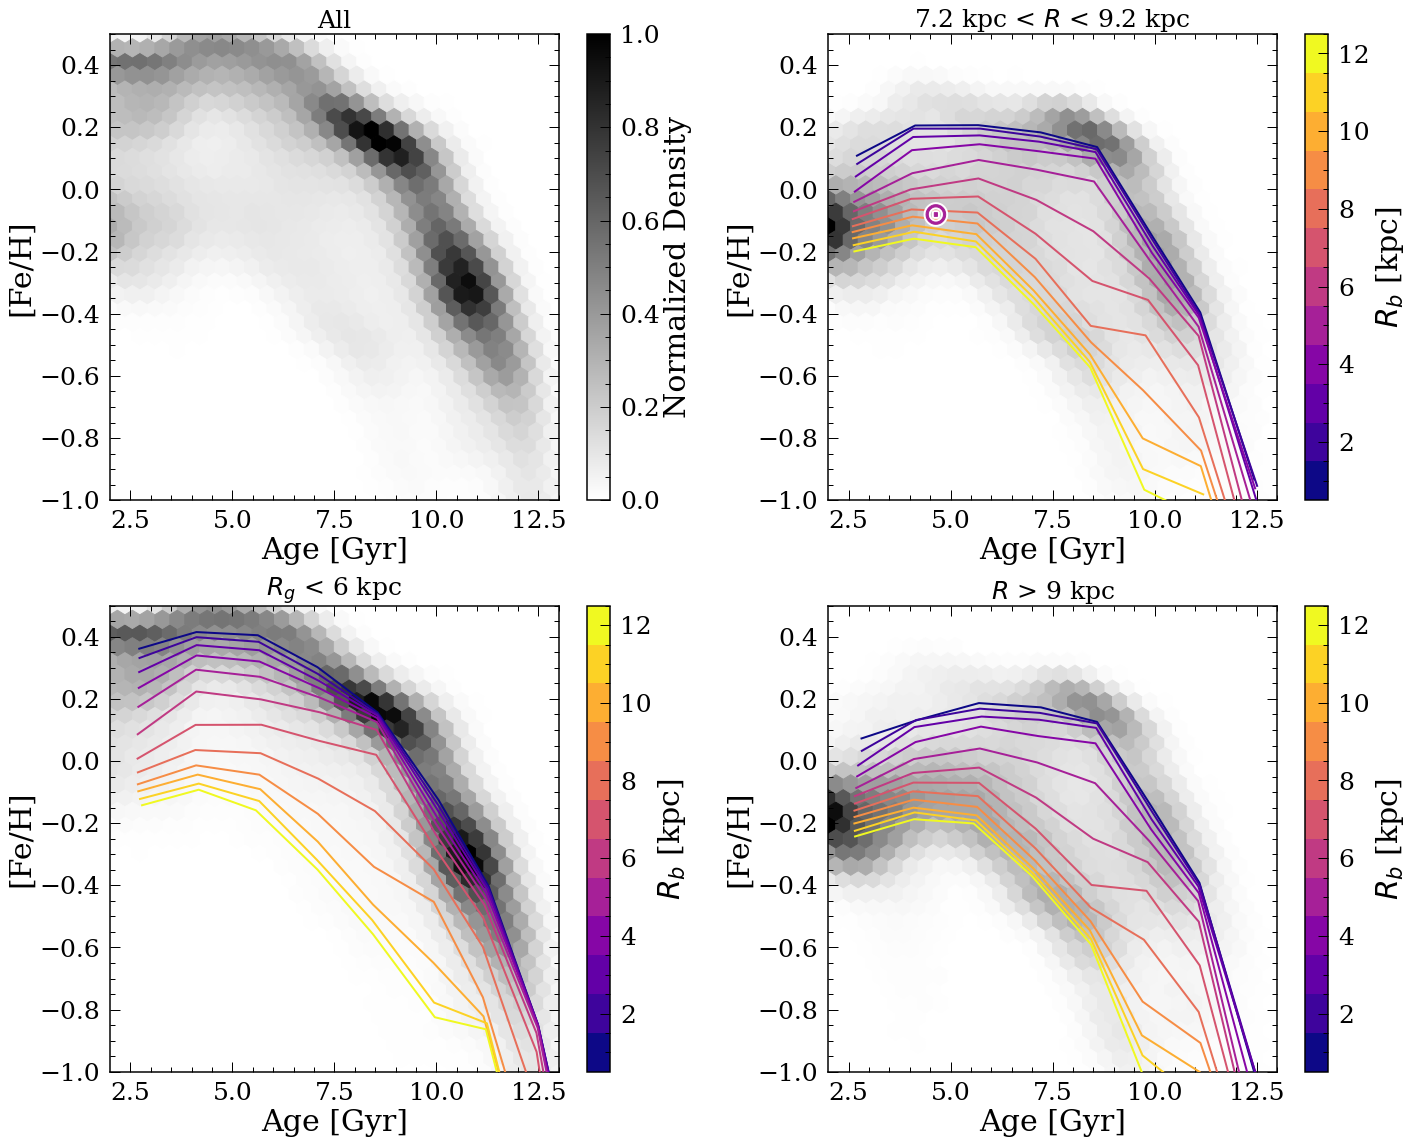

In [14]:

cutbin = 50
import warnings
warnings.filterwarnings('ignore')
def drawArrow(A, B, colors):
    plt.arrow(A[0], A[1], B[0] - A[0], B[1] - A[1],
              head_width=0.01, head_length=0.03, 
              length_includes_head = True,
              color=colors)
    
agebin = np.linspace(2,15,10)
Rbbin = np.linspace(0.5,12.5,13)

colors = getcolor(range(len(Rbbin)-1))

sub_tryRb_sn = data.loc[abs(data['R']-8.2)<1].reset_index(drop=True)



plt.figure(figsize=(20,16))
plt.subplot(2,2,2)
plt.hexbin(sub_tryRb_sn['age_new'], sub_tryRb_sn['feh_new'], 
          extent=(2,13,-1,0.5), gridsize=30, mincnt=1,
          cmap='binary')
#yedges, xedges, H = coldensity(sub_tryRb_sn['AGE'], 
#                               sub_tryRb_sn['FEH'],binsize=30,
#          extend=(2,13,-1,0.5))

#plt.pcolormesh(yedges, xedges, H, vmin=0, vmax=1)



meanfeh = np.zeros((len(agebin)-1,len(Rbbin)-1))
meanafe = np.zeros((len(agebin)-1,len(Rbbin)-1))

for j in range(len(Rbbin)-1):
    for i in range(len(agebin)-1):
        m = (sub_tryRb_sn['age_new']>agebin[i])&(sub_tryRb_sn['age_new']<agebin[i+1])
        m = m&(sub_tryRb_sn['rbir_new']>Rbbin[j])
        m = m&(sub_tryRb_sn['rbir_new']<Rbbin[j+1])
        if sum(m)<cutbin:
            meanfeh[i,j] = np.nan
            meanafe[i,j] = np.nan
        else:
            meanfeh[i,j] = np.median(pd.Series(sub_tryRb_sn['age_new'].values[m]).dropna())
            meanafe[i,j] = np.median(pd.Series(sub_tryRb_sn['feh_new'].values[m]).dropna())
    plt.plot(meanfeh[:,j], meanafe[:,j], '-', color=colors[j], linewidth=2,
            zorder=10)

    """plt.scatter(meanfeh[:,j], meanafe[:,j], c = colors[j], 
                s=80, edgecolor='w',
                cmap=plt.get_cmap('plasma', len(Rbbin)-1),
               vmin=Rbbin[0], vmax=Rbbin[-1],zorder=9)"""
    
#for i in range(len(agebin)-1):
#    plt.plot(meanfeh[i,:], meanafe[i,:], '--', color='w',zorder=4)



plt.scatter(-100, -100, c = 10, 
            s=80, cmap=plt.get_cmap('plasma', len(Rbbin)-1),
           vmin=Rbbin[0], vmax=Rbbin[-1])
plt.scatter(4.6, -0.08, marker='$\\odot$', c='w', s=500, linewidth=5,
           zorder=99)
plt.scatter(4.6, -0.08, c=5, marker='$\\odot$', vmin=Rbbin[0], vmax=Rbbin[-1],
           cmap=plt.get_cmap('plasma',len(Rbbin)-1), s=500,zorder=100)

plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H]')
cb = plt.colorbar()
cb.set_label('$R_b$ [kpc]')
plt.xlim([2,13])
plt.ylim([-1,0.5])
plt.title('7.2 kpc < $R$ < 9.2 kpc', fontsize=25)
#plt.title('7.7 kpc < Rb_corrected < 8.7 kpc', fontsize=25)





sub_tryRb_sn = data.loc[abs(data['R'])>9].reset_index(drop=True)

plt.subplot(2,2,4)
plt.hexbin(sub_tryRb_sn['age_new'], sub_tryRb_sn['feh_new'], 
          extent=(2,13,-1,0.5), gridsize=30, mincnt=1,
          cmap='binary')
#yedges, xedges, H = coldensity(sub_tryRb_sn['AGE'], 
#                               sub_tryRb_sn['FEH'],binsize=30,
#          extend=(2,13,-1,0.5))

#plt.pcolormesh(yedges, xedges, H, vmin=0, vmax=1)
meanfeh = np.zeros((len(agebin)-1,len(Rbbin)-1))
meanafe = np.zeros((len(agebin)-1,len(Rbbin)-1))

for j in range(len(Rbbin)-1):
    for i in range(len(agebin)-1):
        m = (sub_tryRb_sn['age_new']>agebin[i])&(sub_tryRb_sn['age_new']<agebin[i+1])
        m = m&(sub_tryRb_sn['rbir_new']>Rbbin[j])
        m = m&(sub_tryRb_sn['rbir_new']<Rbbin[j+1])
        if sum(m)<cutbin:
            meanfeh[i,j] = np.nan
            meanafe[i,j] = np.nan
        else:
            meanfeh[i,j] = np.median(pd.Series(sub_tryRb_sn['age_new'].values[m]).dropna())
            meanafe[i,j] = np.median(pd.Series(sub_tryRb_sn['feh_new'].values[m]).dropna())
    plt.plot(meanfeh[:,j], meanafe[:,j], '-', color=colors[j], linewidth=2,
            zorder=10)

    """plt.scatter(meanfeh[:,j], meanafe[:,j], c = colors[j], 
                s=80, edgecolor='w',
                cmap=plt.get_cmap('plasma', len(Rbbin)-1),
               vmin=Rbbin[0], vmax=Rbbin[-1],zorder=9)"""
    
#for i in range(len(agebin)-1):
#    plt.plot(meanfeh[i,:], meanafe[i,:], '--', color='w',zorder=4)




plt.scatter(-100, -100, c = 10, 
            s=80, cmap=plt.get_cmap('plasma', len(Rbbin)-1),
           vmin=Rbbin[0], vmax=Rbbin[-1])

plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H]')
cb = plt.colorbar()
cb.set_label('$R_b$ [kpc]')
plt.xlim([2,13])
plt.ylim([-1,0.5])
plt.title('$R$ > 9 kpc', fontsize=25)






sub_tryRb_sn = data.loc[abs(data['R'])<6].reset_index(drop=True)

plt.subplot(2,2,3)
plt.hexbin(sub_tryRb_sn['age_new'], sub_tryRb_sn['feh_new'], 
          extent=(2,13,-1,0.5), gridsize=30, mincnt=1,
          cmap='binary')
#yedges, xedges, H = coldensity(sub_tryRb_sn['AGE'], 
#                               sub_tryRb_sn['FEH'],binsize=30,
#          extend=(2,13,-1,0.5))

#plt.pcolormesh(yedges, xedges, H, vmin=0, vmax=1)
meanfeh = np.zeros((len(agebin)-1,len(Rbbin)-1))
meanafe = np.zeros((len(agebin)-1,len(Rbbin)-1))

for j in range(len(Rbbin)-1):
    for i in range(len(agebin)-1):
        m = (sub_tryRb_sn['age_new']>agebin[i])&(sub_tryRb_sn['age_new']<agebin[i+1])
        m = m&(sub_tryRb_sn['rbir_new']>Rbbin[j])
        m = m&(sub_tryRb_sn['rbir_new']<Rbbin[j+1])
        if sum(m)<cutbin:
            meanfeh[i,j] = np.nan
            meanafe[i,j] = np.nan
        else:
            meanfeh[i,j] = np.median(pd.Series(sub_tryRb_sn['age_new'].values[m]).dropna())
            meanafe[i,j] = np.median(pd.Series(sub_tryRb_sn['feh_new'].values[m]).dropna())
    plt.plot(meanfeh[:,j], meanafe[:,j], '-', color=colors[j], linewidth=2,
            zorder=10)
    
    """plt.scatter(meanfeh[:,j], meanafe[:,j], c = colors[j], 
                s=80, edgecolor='w',
                cmap=plt.get_cmap('plasma', len(Rbbin)-1),
               vmin=Rbbin[0], vmax=Rbbin[-1],zorder=9)"""
    
#for i in range(len(agebin)-1):
#    plt.plot(meanfeh[i,:], meanafe[i,:], '--', color='w',zorder=4)




plt.scatter(-100, -100, c = 10, 
            s=80, cmap=plt.get_cmap('plasma', len(Rbbin)-1),
           vmin=Rbbin[0], vmax=Rbbin[-1],zorder=1)

plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H]')
cb = plt.colorbar()
cb.set_label('$R_b$ [kpc]')
plt.xlim([2,13])
plt.ylim([-1,0.5])
plt.title('$R_g$ < 6 kpc', fontsize=25)







#Rbbin = np.linspace(0,15,16)

plt.subplot(2,2,1)
"""plt.hexbin(sub_tryRb['AGE'], sub_tryRb['FEH'], 
           C=sub_tryRb['Rb'],vmin=0,vmax=12,
          extent=(0,13,-1,0.5), gridsize=50, mincnt=10,
          cmap=plt.get_cmap('plasma',10))"""

hb = plt.hexbin(data['age_new'], data['feh_new'], 
          extent=(2,13,-1,0.5), gridsize=30, mincnt=1,
          cmap='binary')
#yedges, xedges, H = coldensity(sub_tryRb_sn['AGE'], 
#                               sub_tryRb_sn['FEH'],binsize=30,
#          extend=(2,13,-1,0.5))

#plt.pcolormesh(yedges, xedges, H, vmin=0, vmax=1)
meanfeh = np.zeros((len(agebin)-1,len(Rbbin)-1))
meanafe = np.zeros((len(agebin)-1,len(Rbbin)-1))

for j in range(len(Rbbin)-1):
    for i in range(len(agebin)-1):
        m = (data['age_new']>agebin[i])&(data['age_new']<agebin[i+1])
        m = m&(data['rbir_new']>Rbbin[j])
        m = m&(data['rbir_new']<Rbbin[j+1])
        if sum(m)<cutbin:
            meanfeh[i,j] = np.nan
            meanafe[i,j] = np.nan
        else:
            meanfeh[i,j] = np.median(pd.Series(data['age_new'].values[m]).dropna())
            meanafe[i,j] = np.median(pd.Series(data['feh_new'].values[m]).dropna())
    #plt.plot(meanfeh[:,j], meanafe[:,j], '-', color=colors[j], linewidth=2,
    #        zorder=10)
    #plt.plot(meanfeh[:,j], meanafe[:,j], '-', color='w', linewidth=4,
    #        zorder=9)
    """plt.scatter(meanfeh[:,j], meanafe[:,j], c = colors[j], 
                s=80, edgecolor='w',
                cmap=plt.get_cmap('plasma', len(Rbbin)-1),
               vmin=Rbbin[0], vmax=Rbbin[-1],zorder=9)"""

plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H]')
cb = plt.colorbar()
cb.set_ticks(np.linspace(hb.get_array().min(), hb.get_array().max(), 6))
cb.set_ticklabels(['%.1f'%i for i in np.linspace(0, 1., 6)])
cb.set_label('Normalized Density')
plt.xlim([2,13])
plt.ylim([-1,0.5])
plt.title('All', fontsize=25)

plt.tight_layout()






100%|██████████| 39/39 [00:00<00:00, 502.83it/s]


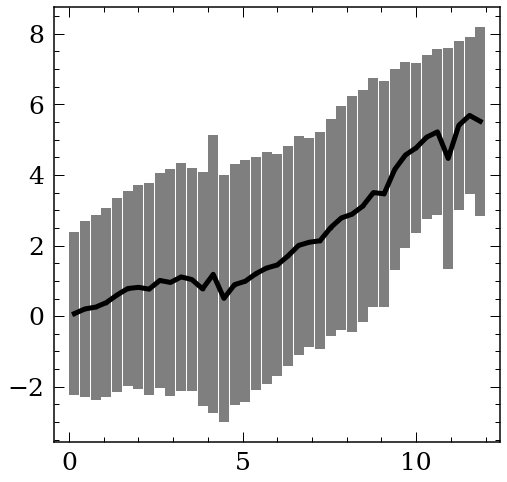

In [15]:
agebincalc_rm = np.linspace(0,12,40)
sub_tryRb_sub = data
sub_tryRb_sub = sub_tryRb_sub.loc[sub_tryRb_sub['rbir_new']<20]
sub_tryRb_sub = sub_tryRb_sub.loc[sub_tryRb_sub['feh']>-1]
sub_tryRb_sub = sub_tryRb_sub.loc[abs(sub_tryRb_sub['R']-8.2)<0.5]

mean_dr = np.zeros(len(agebincalc_rm)-1)
std_dr = np.zeros(len(agebincalc_rm)-1)

mean_blr = np.zeros(len(agebincalc_rm)-1)
std_blr = np.zeros(len(agebincalc_rm)-1)

for i in trange(len(agebincalc_rm)-1):
    sub_tryRb_sing = sub_tryRb_sub.loc[(sub_tryRb_sub['age']>agebincalc_rm[i])&(sub_tryRb_sub['age']<agebincalc_rm[i+1])]

    sub_tryRb_sing = sub_tryRb_sing.dropna(subset=['rbir_new','R'])
    
    if len(sub_tryRb_sing)<30:
        mean_dr[i] = np.nan
        std_dr[i] = np.nan
        
        mean_blr[i] = np.nan
        std_blr[i] = np.nan
        continue
    
    mean_dr[i] = np.mean(sub_tryRb_sing['R']-sub_tryRb_sing['rbir_new'])
    std_dr[i] = np.std(sub_tryRb_sing['R']-sub_tryRb_sing['rbir_new'])

        
plt.figure(figsize=(8,8))

plt.errorbar((agebincalc_rm[1:]+agebincalc_rm[:-1])/2, mean_dr,
             yerr=std_dr, fmt='.',  color='k', alpha=0.5,
            linewidth=10)
plt.plot((agebincalc_rm[1:]+agebincalc_rm[:-1])/2, mean_dr,'-',
         color='k', linewidth=5, label='Migration')



## + err

In [13]:
import warnings
warnings.filterwarnings('ignore')

data['age_new'] = [np.random.normal(i, 0.5) for i in data['age']]
data['rbir_new'] = [np.random.normal(i, 1.12+1) for i in data['R_bir']]
data['R_new'] = [np.random.normal(i, 0.31) for i in data['R']]


In [14]:
def monoage_line(feh,r,age,agebin=np.linspace(0,14,8),
                feherr=[],xlims=[0,25],checkplt=True):
    colors = getcolor(range(len(agebin)+1))
    slopes = np.zeros(len(agebin)-1)
    fehscatter = np.zeros(len(agebin)-1)
    

    for i in trange(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        if sum(m)==0:
            fehscatter[i] = np.nan
            continue
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        if sum(m2)==0:
            fehscatter[i] = np.nan
            continue
        p = fitpoints(r_sing[m2], feh_sing[m2]) 
        slopes[i] = p[1]
        fehscatter[i] = np.std(feh_sing[m2]-p(r_sing[m2]))
        if len(feherr)>0:
            fehscatter[i] = np.sqrt(fehscatter[i]**2-np.mean(feherr[m][m2])**2)
            #print(np.std(feh_sing[m2]-p(r_sing[m2])))
        if checkplt:
            plt.figure(figsize=(8,8))
            plt.plot(r_sing[m2], feh_sing[m2], 'r.')
            plt.plot(r_sing[m2], p(r_sing[m2]), 'k-',
                    label='%.2f Rb+%.2f'%(p[1],p[0]))
            plt.plot([0,15], [np.percentile(feh_sing[m2],95),np.percentile(feh_sing[m2],95)],'b-')
            plt.plot([0,15], [np.percentile(feh_sing[m2],5),np.percentile(feh_sing[m2],5)],'b-')
            plt.plot([np.percentile(r_sing[m2],95),np.percentile(r_sing[m2],95)], [-3,0.5],'b-')
            plt.plot([np.percentile(r_sing[m2],5),np.percentile(r_sing[m2],5)], [-3,0.5],'b-')
            
            plt.xlabel('Rb [kpc]')
            plt.ylabel('[Fe/H]')
            plt.title('%.2f Gyr - %.2f Gyr'%(agebin[i],agebin[i+1]),
                     fontsize=25)
            plt.legend()
            plt.savefig(str(len(agebin)-1-i)+'.png')

    return (agebin[:-1]+agebin[1:])/2, slopes, fehscatter

In [15]:
#agebin = np.linspace(2,15,10)

100%|██████████| 2/2 [00:38<00:00, 19.19s/it]


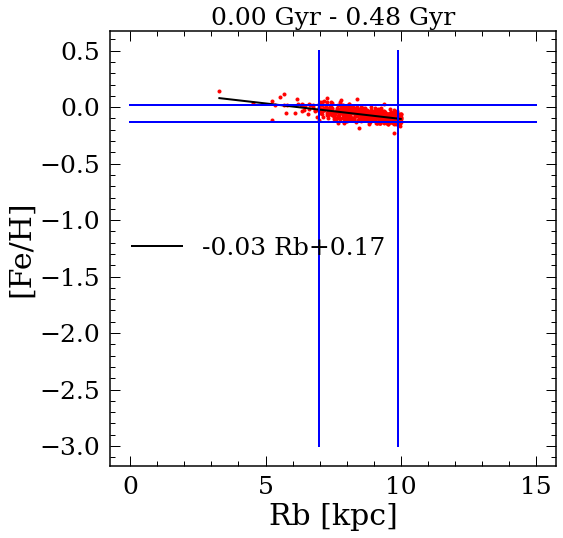

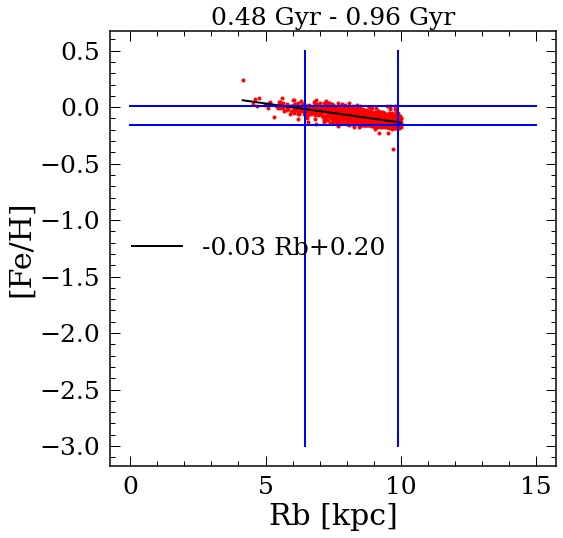

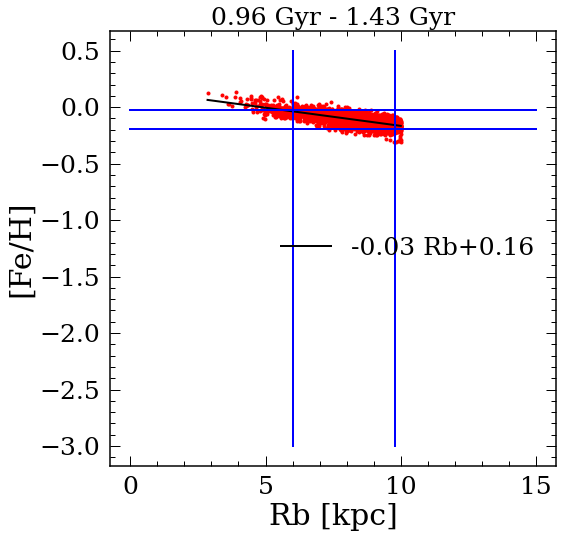

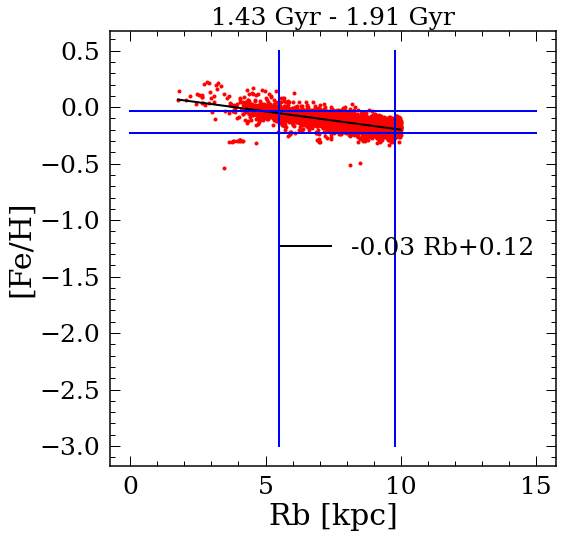

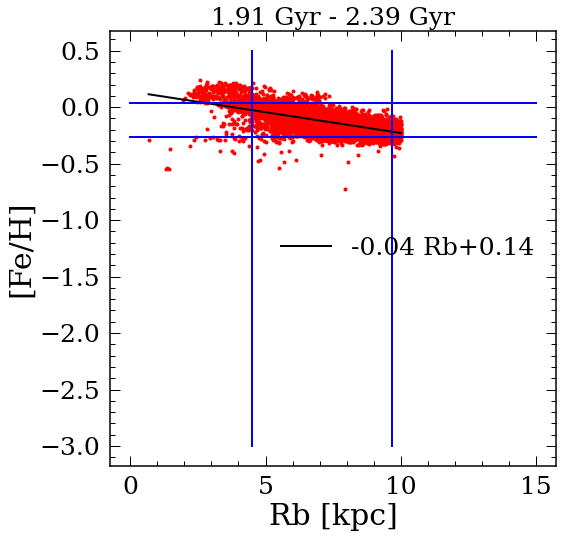

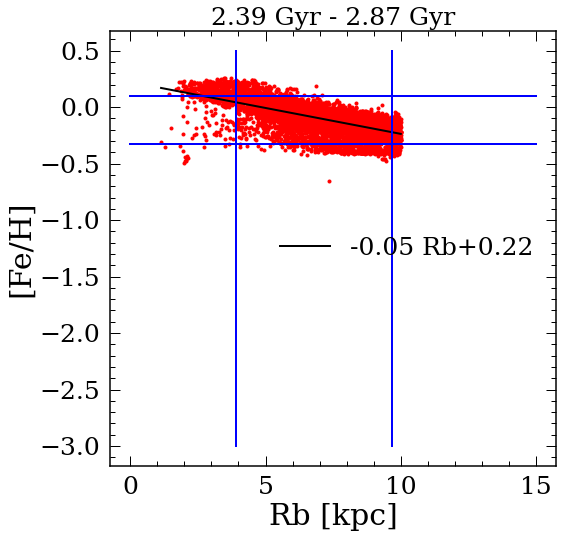

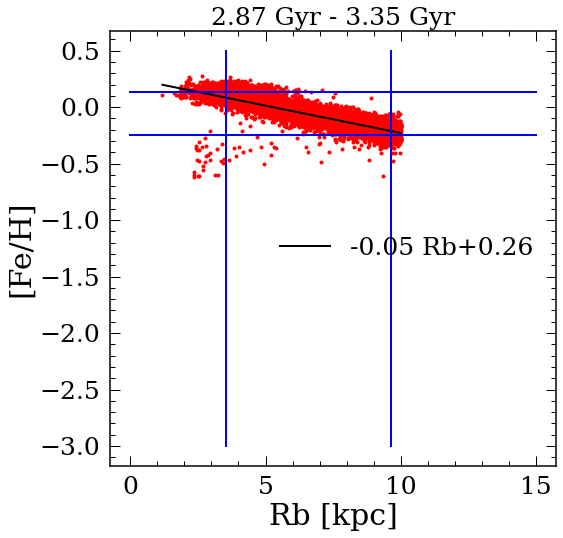

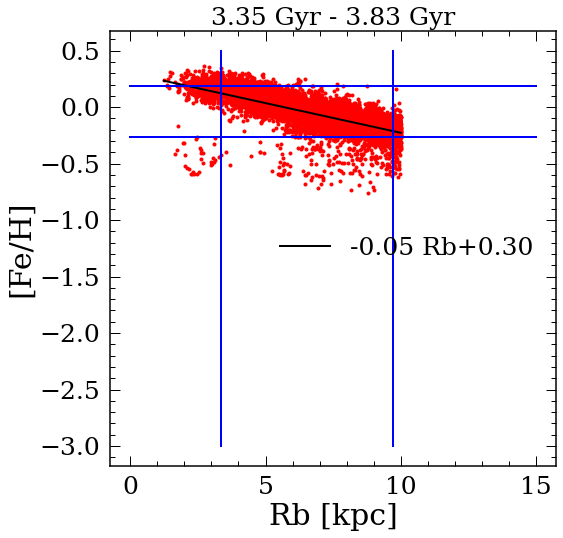

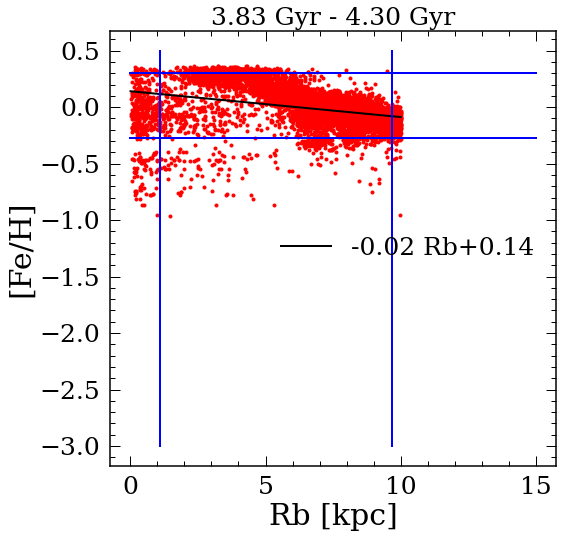

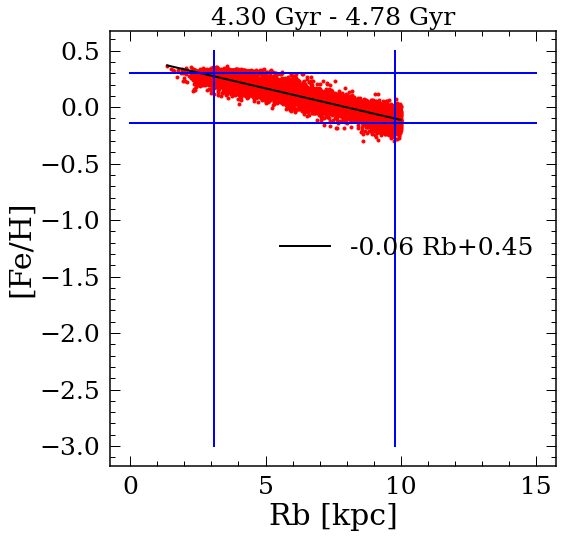

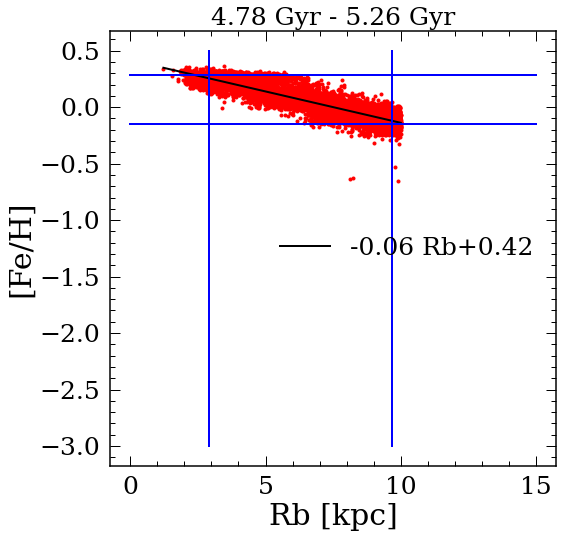

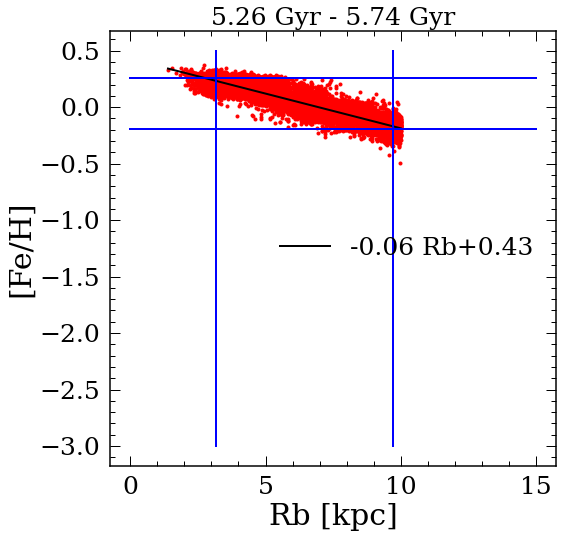

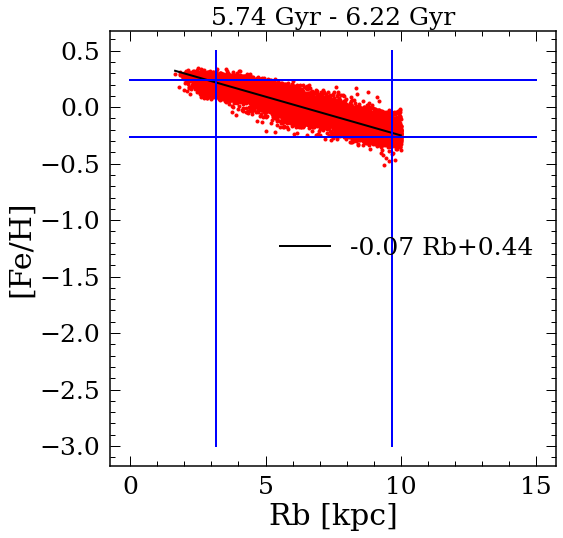

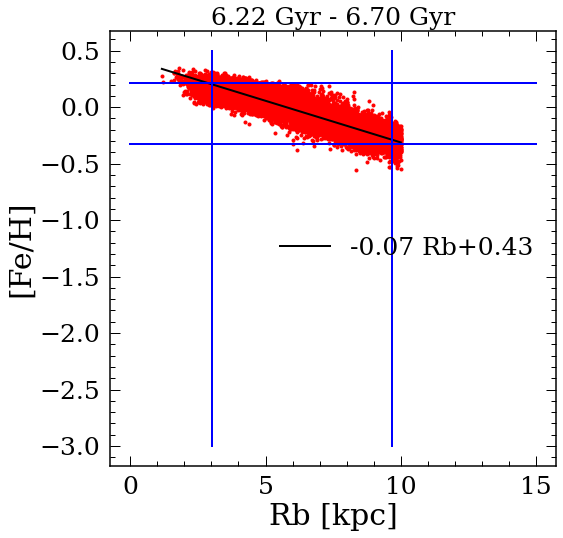

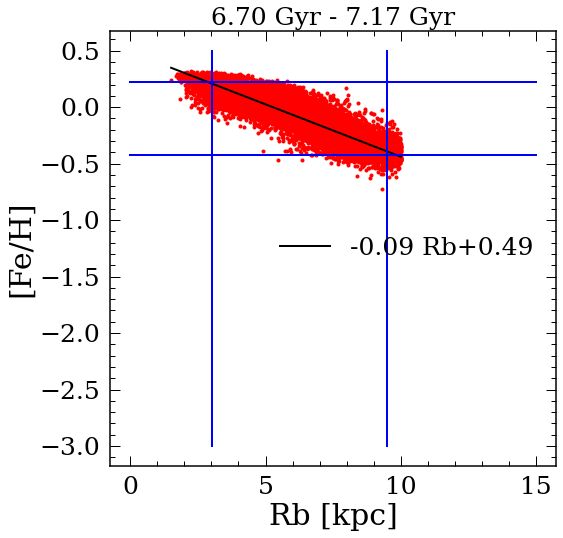

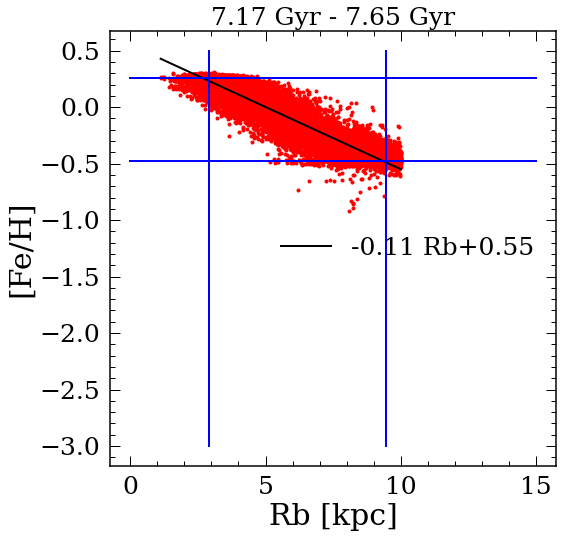

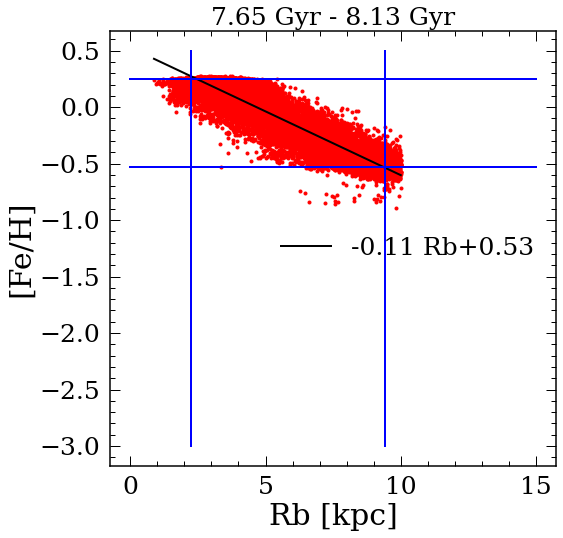

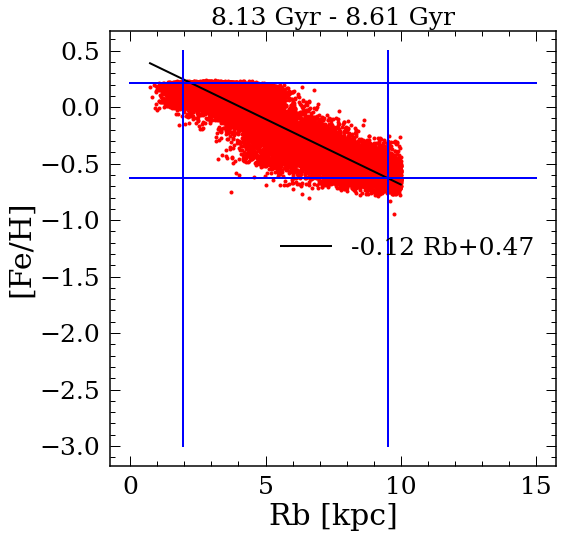

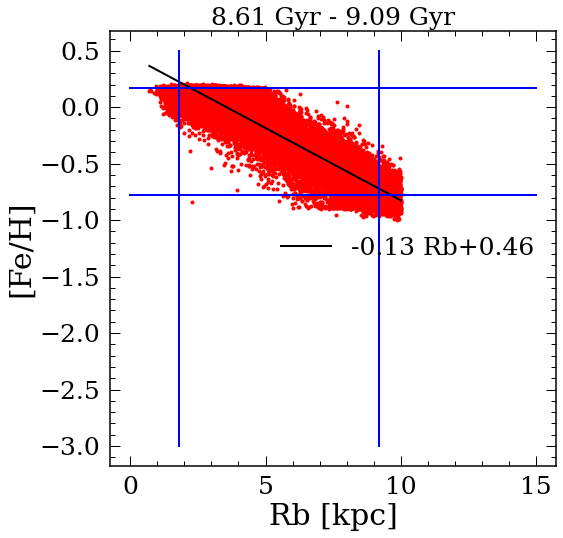

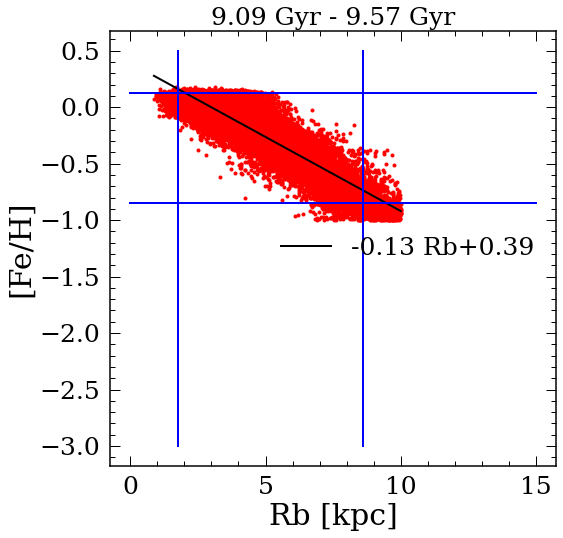

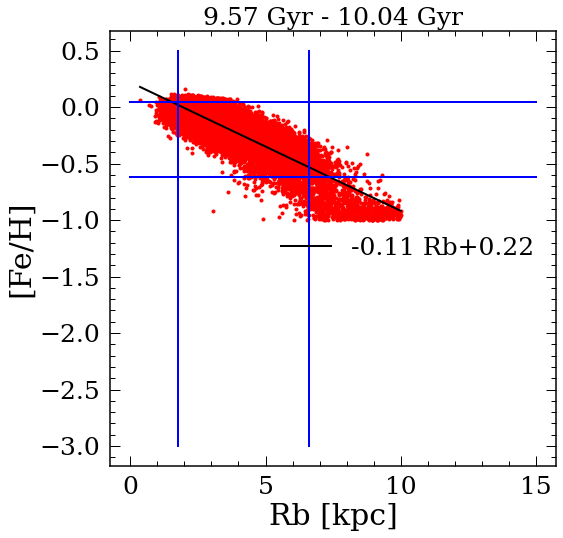

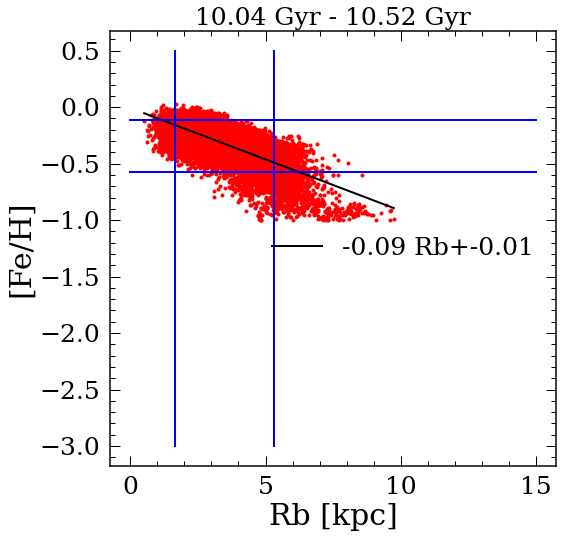

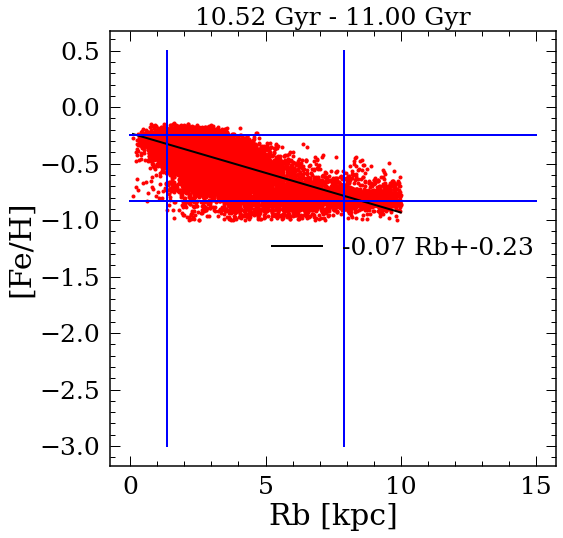

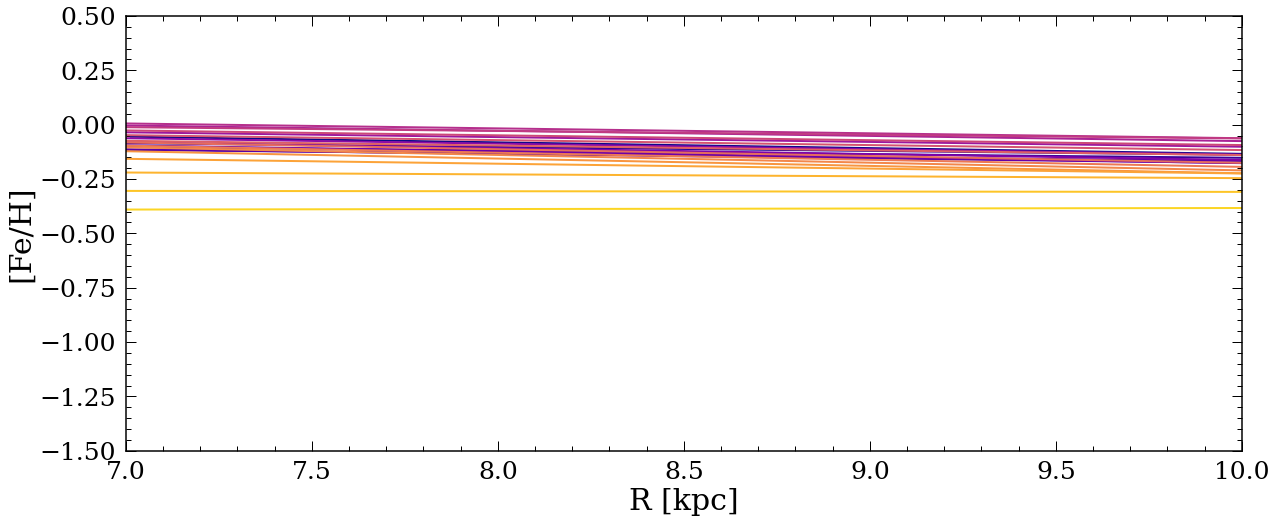

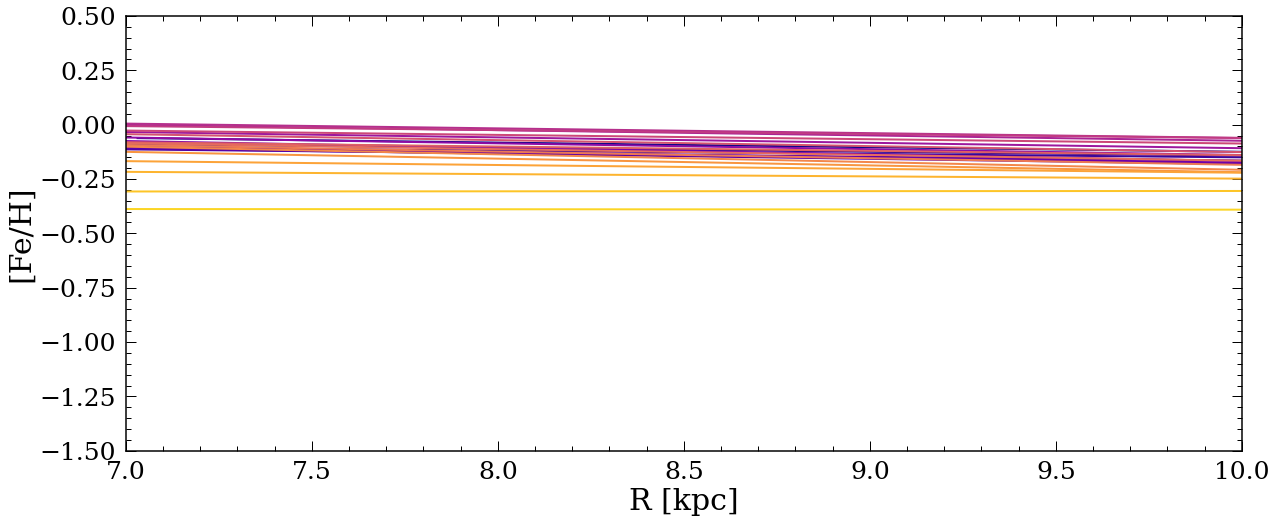

In [54]:

def monoage_line_range(feh,r,age,agebin=np.linspace(0,14,8),xlims=[6,12],ylims=[-1.5,0.5],
                feherr=[],plotlegend=True):
    colors = getcolor(range(len(agebin)+1))
    slopes = np.zeros(len(agebin)-1)
    fehscatter = np.zeros(len(agebin)-1)
    
    plt.figure(figsize=(20,8))
    for i in trange(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        if sum(m)==0:
            fehscatter[i] = np.nan
            continue
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        if sum(m2)==0:
            fehscatter[i] = np.nan
            continue
        p = fitpoints(r_sing[m2], feh_sing[m2]) 
        slopes[i] = p[1]
        fehscatter[i] = np.percentile(feh_sing[m2],95)-np.percentile(feh_sing[m2],5)
        if len(feherr)>0:
            fehscatter[i] = np.sqrt(fehscatter[i]**2-np.mean(feherr[m][m2])**2)
            #print(np.std(feh_sing[m2]-p(r_sing[m2])))
        plt.plot(r_sing[m2], p(r_sing[m2]), color=colors[i], 
                 label='[%.2f Gyr, %.2f Gyr]'%(agebin[i],agebin[i+1]))
    if plotlegend:
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=3)
    plt.xlabel('R [kpc]')
    plt.ylabel('[Fe/H]')
    plt.xlim(xlims)
    plt.ylim(ylims)
    return (agebin[:-1]+agebin[1:])/2, slopes, fehscatter


m = (data['R']>6)&(data['R']<11)
m = m&(data['feh']>-1)
m = m&(abs(data['z'])>1)
data_calc = data[m].reset_index(drop=True)

age_calc = np.linspace(0,11,24)
slopes_arr = np.zeros((len(age_calc)-1, 2))
fehscatter_arr = np.zeros((len(age_calc)-1, 2))

ages, slopes_rbir, fehscatter_rbir = monoage_line(data['feh'].values[m], 
                                        data['R_bir'].values[m], 
                                        data['age'].values[m],
                                        agebin=age_calc,
                                                 xlims=[0,10])

for i in trange(2):
    data_calc['age_new'] = [np.random.normal(i, 0.5) for i in data_calc['age']]
    data_calc['R_new'] = [np.random.normal(i, 0.31) for i in data_calc['R']]
    data_calc['feh_new'] = [np.random.normal(i, 0.03) for i in data_calc['feh']]
    ages, slopes_arr[:,i], fehscatter_arr[:,i] = monoage_line_range(data_calc['feh_new'].values, 
                                            data_calc['R_new'].values, 
                                            data_calc['age_new'].values,
                                            agebin=age_calc,
                                            xlims=[7,10],plotlegend=False)




In [17]:
data.columns

Index(['vx_birth', 'vy_today', 'vz_today', 'z_today', 'vy_birth', 'ofe',
       'iords', 'vx_today', 'x_today', 'feh', 'x_birth', 'y_birth', 'vz_birth',
       'mass', 'y_today', 'oxh', 'z_birth', 'age', 'iord', 'vx', 'vy', 'vz',
       'x', 'y', 'z', 'Jr', 'Jphi', 'Jz', 'R', 'R_bir', 'feh_scale',
       'ofe_scale', 'hi_low', 'age_new', 'rbir_new', 'feh_new', 'R_new'],
      dtype='object')

In [18]:
def calcvel(vx, vy, x, y, v0):
    R = np.sqrt(x**2+y**2)
    vr = (x * vx + y * vy)/R
    vphi = (x * vy - y * vx)/R
    ecc = np.sqrt(vr**2 + 2.*(vphi-v0)**2)/(np.sqrt(2.)*v0)
    
    return vr, vphi, ecc

In [19]:
data['vr'], data['vphi'], data['ecc'] = calcvel(data.vx_today, data.vy_today, 
                                                data.x, data.y, 240)


100%|██████████| 2/2 [00:13<00:00,  6.63s/it]


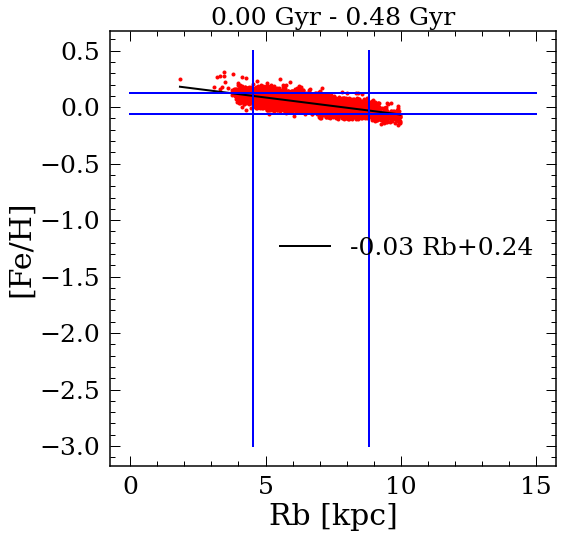

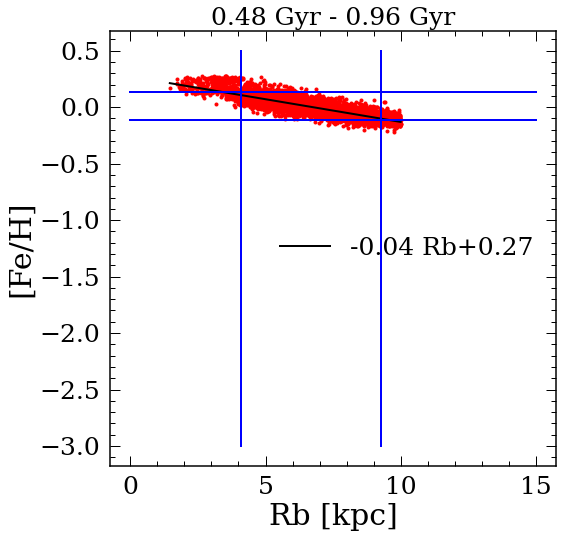

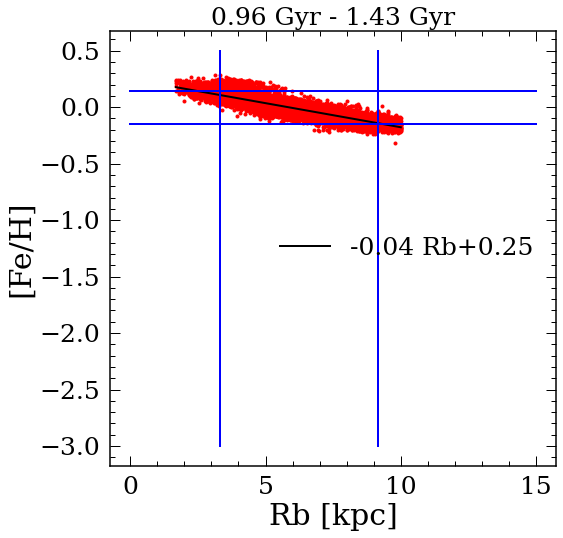

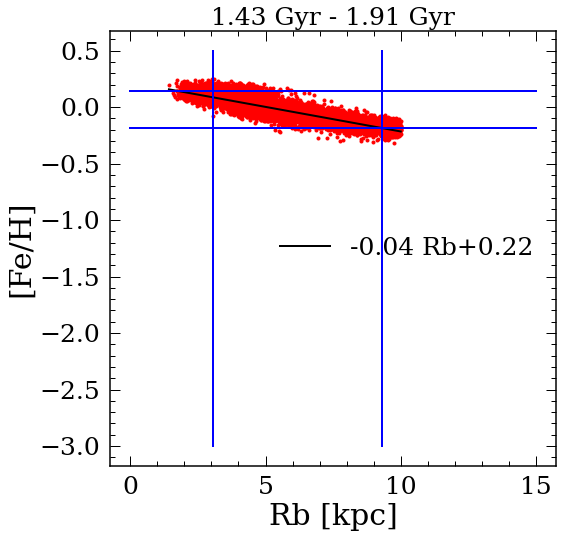

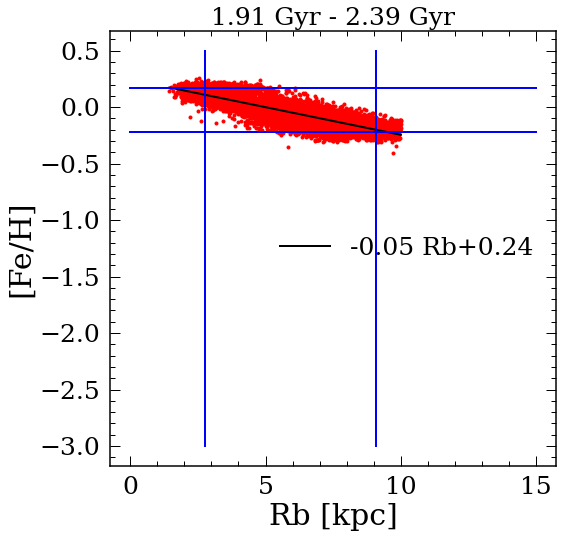

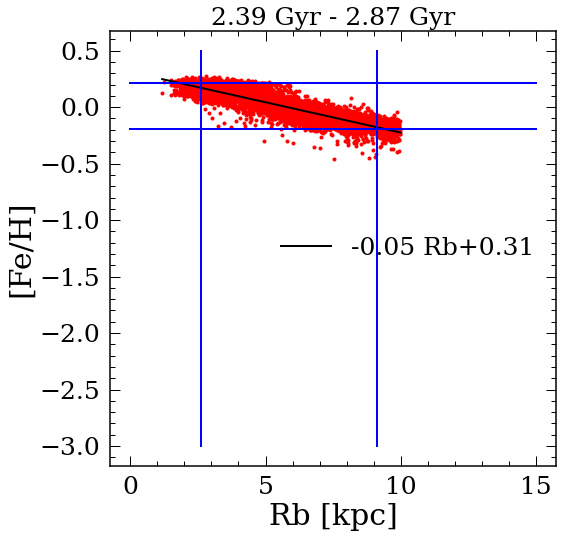

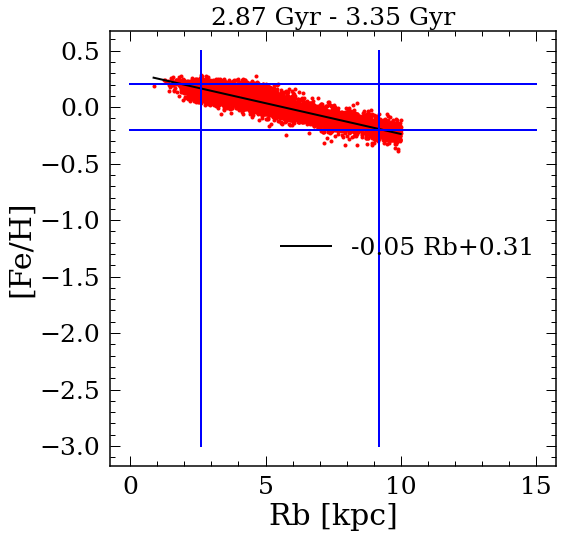

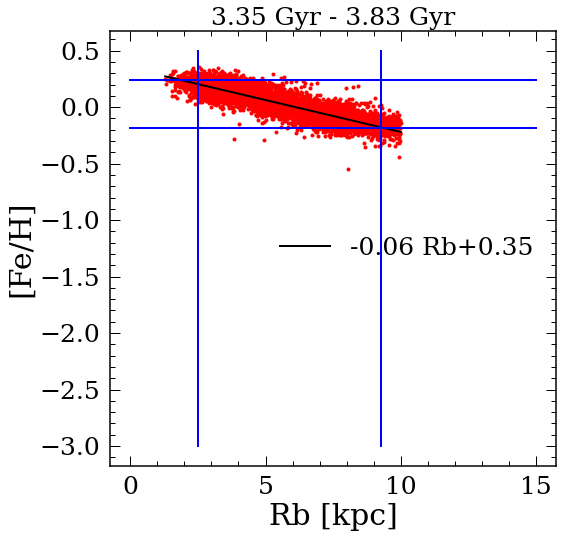

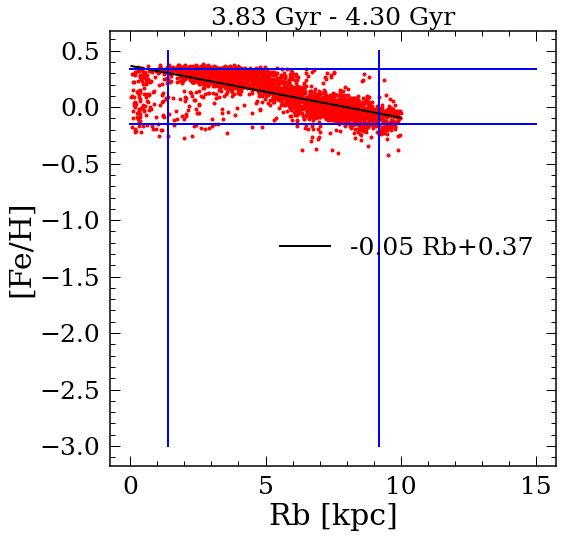

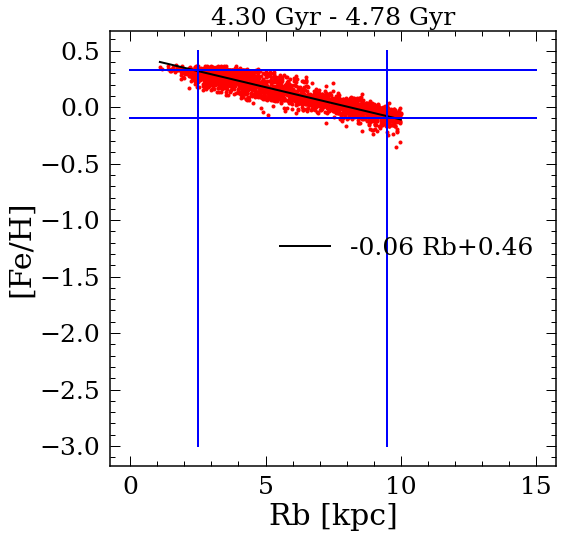

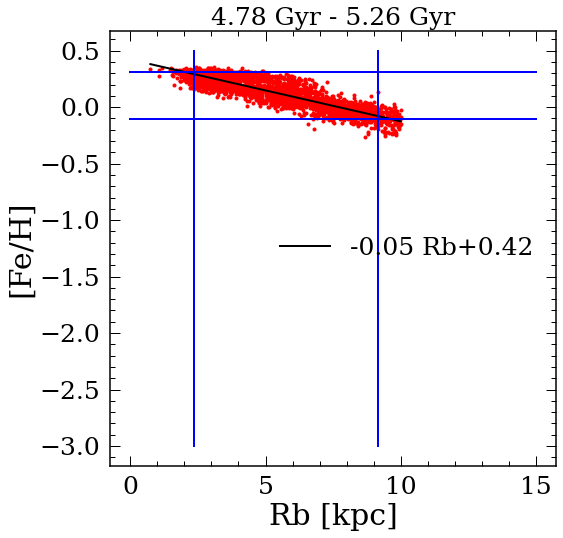

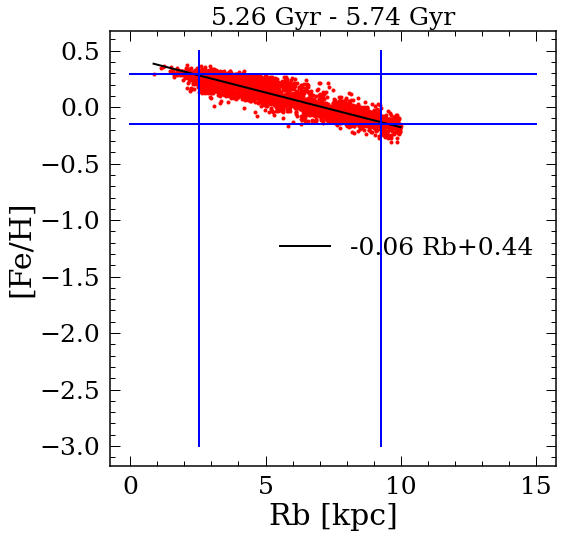

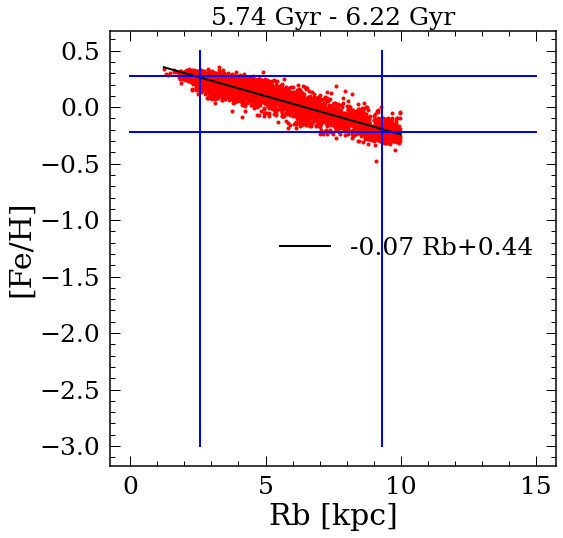

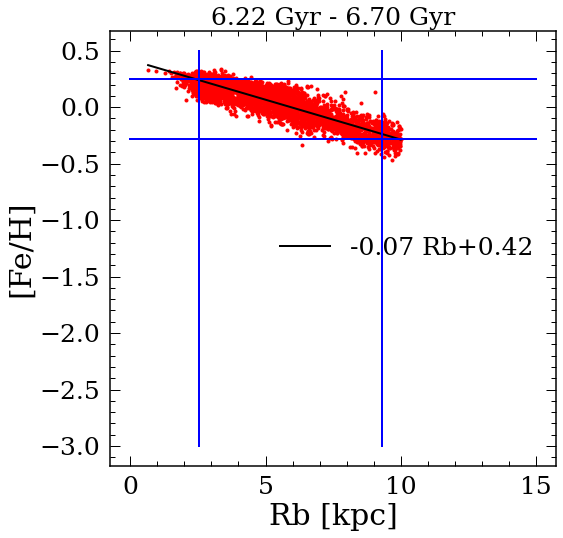

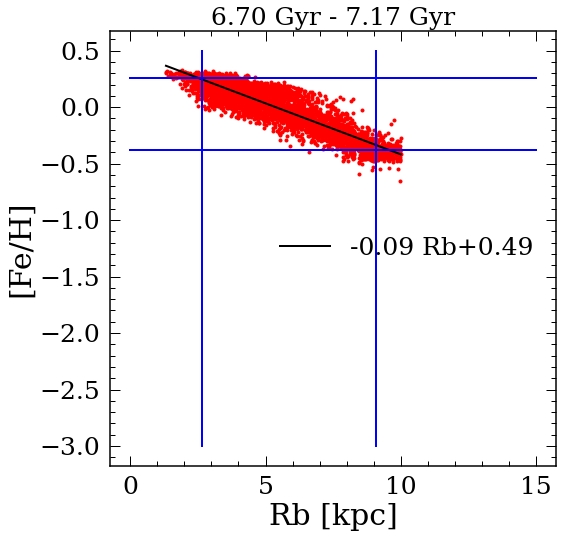

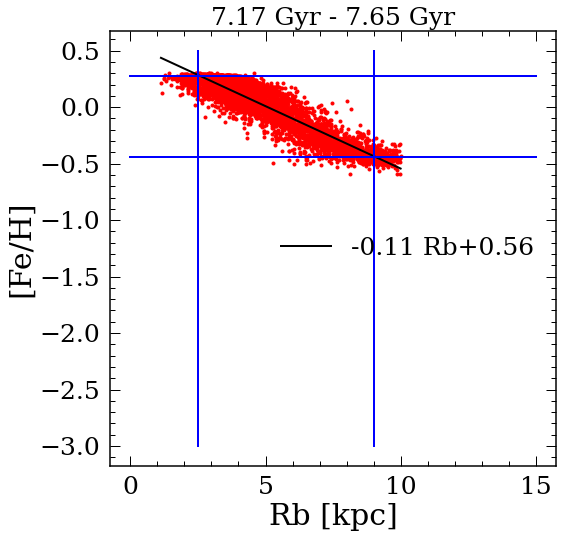

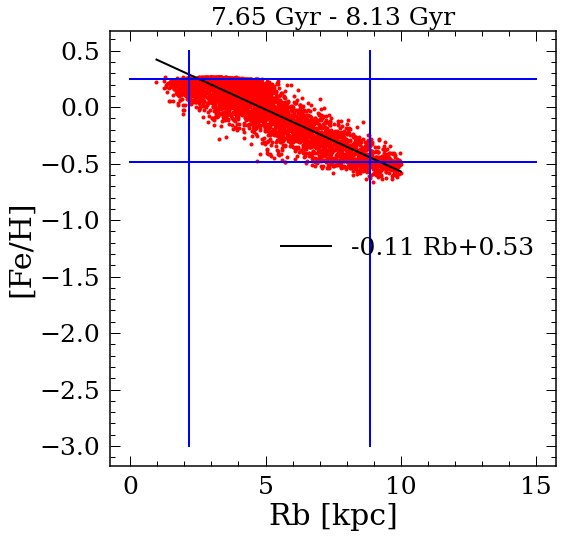

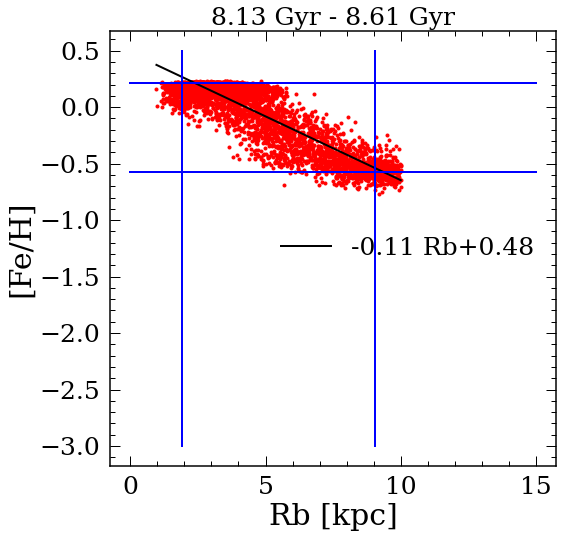

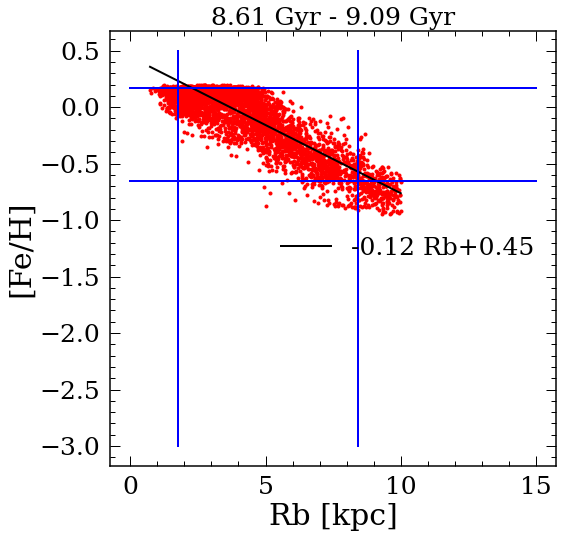

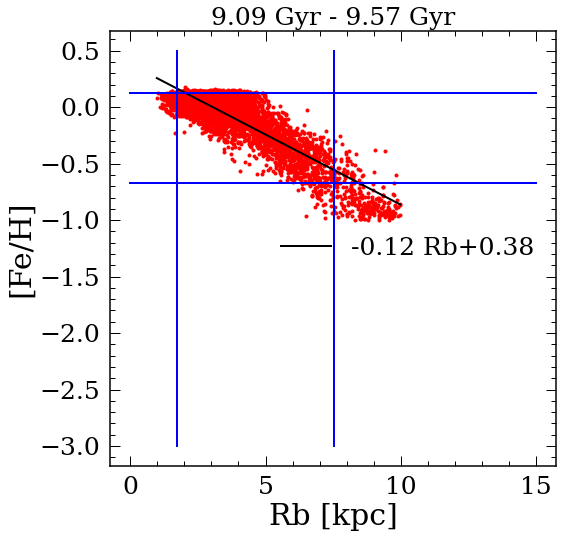

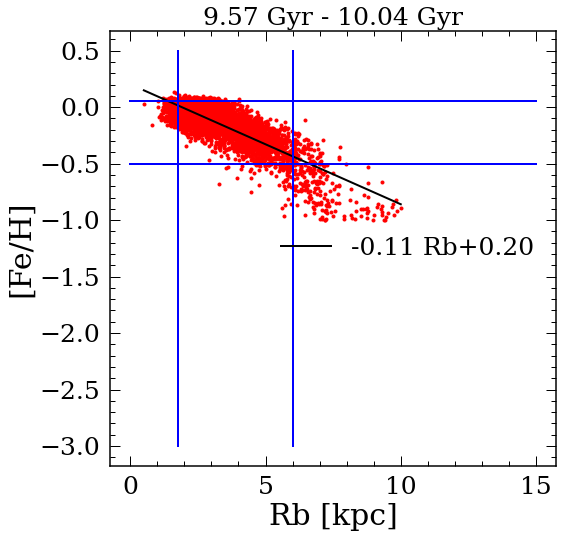

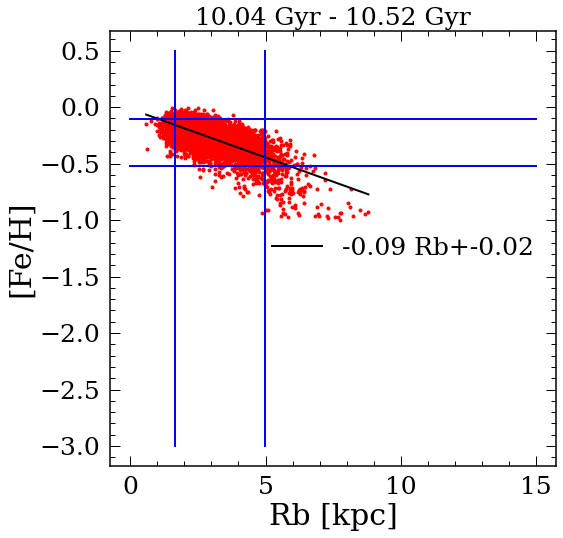

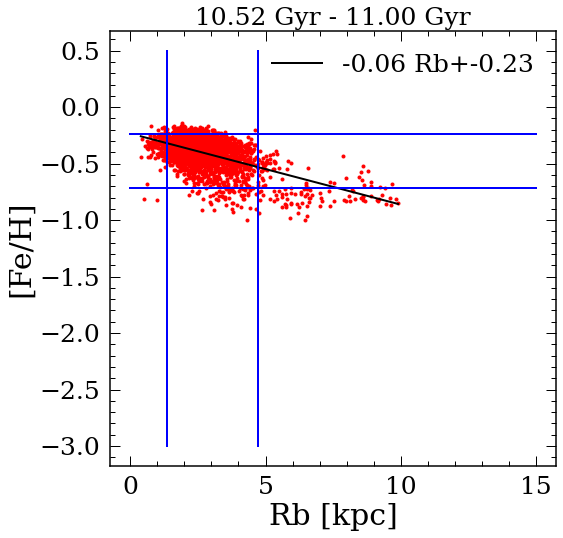

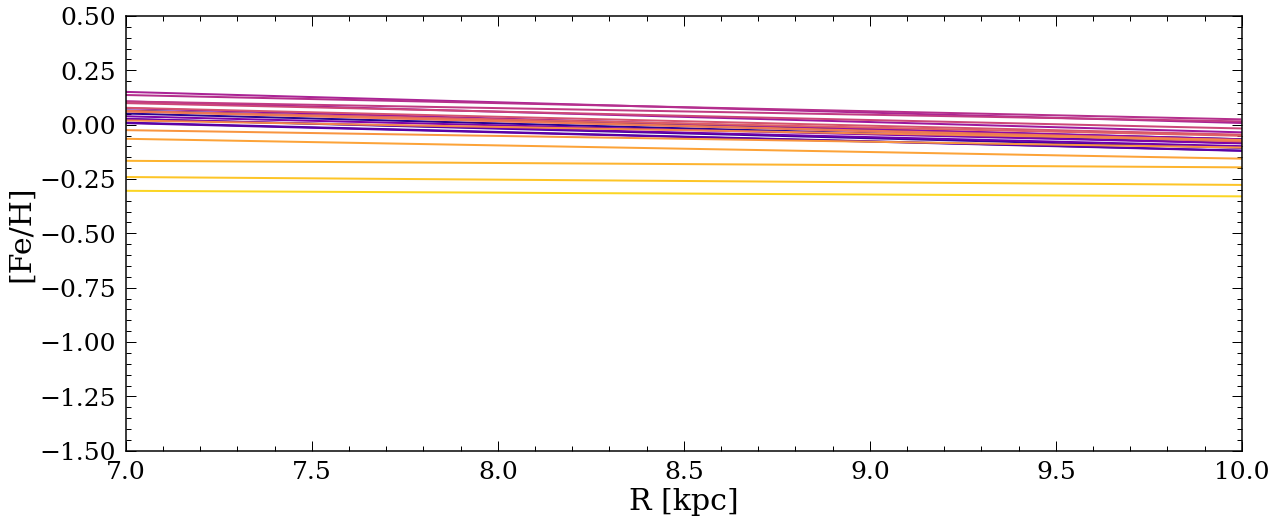

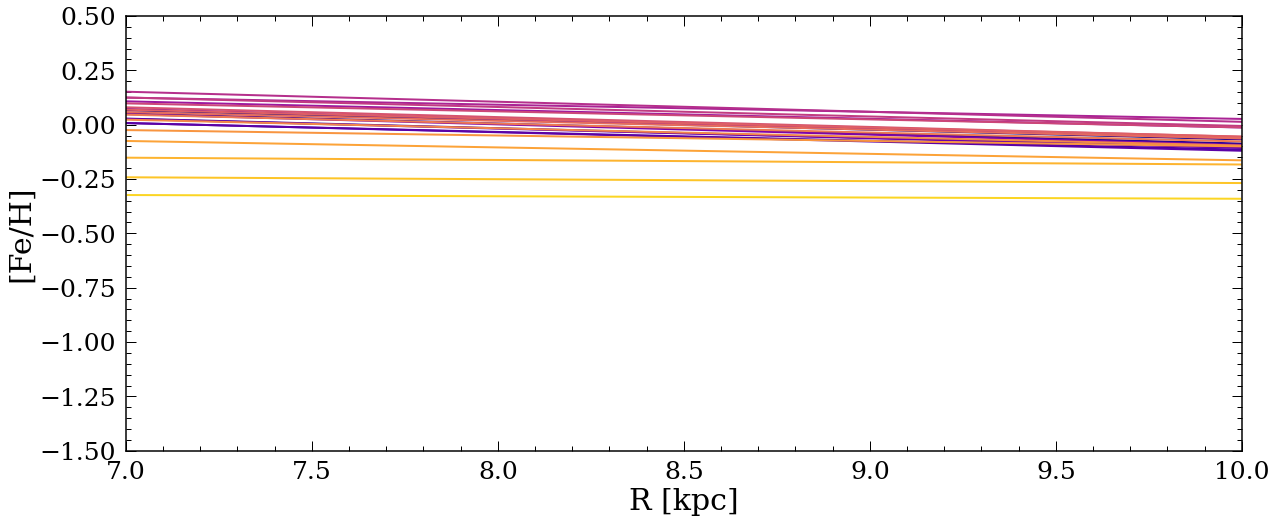

In [55]:

m = (data['R']>6)&(data['R']<11)
m = m&(data['ecc']<0.2)
m = m&(data['feh']>-1)
m = m&(abs(data['z'])<1)

data_calc = data[m].reset_index(drop=True)

ages, slopes_rbir, fehscatter_rbir = monoage_line(data['feh'].values[m], 
                                        data['R_bir'].values[m], 
                                        data['age'].values[m],
                                        agebin=age_calc,
                                                 xlims=[0,10])

for i in trange(2):
    data_calc['age_new'] = [np.random.normal(i, 0.5) for i in data_calc['age']]
    data_calc['R_new'] = [np.random.normal(i, 0.31) for i in data_calc['R']]
    data_calc['feh_new'] = [np.random.normal(i, 0.03) for i in data_calc['feh']]
    ages, slopes_arr[:,i], fehscatter_arr[:,i] = monoage_line_range(data_calc['feh_new'].values, 
                                            data_calc['R_new'].values, 
                                            data_calc['age_new'].values,
                                            agebin=age_calc,
                                            xlims=[7,10],plotlegend=False)
    

In [56]:
"""agebin=np.linspace(0,13,40)
age = data['age'].values
for i in trange(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        if sum(m)==0:
            fehscatter[i] = np.nan
            continue
        data_sing = data[m]
        plt.figure(figsize=(10,8))
        plt.scatter(data_sing['x_birth'], data_sing['y_birth'],
                   c=data_sing['feh'],vmin=-1,vmax=0.5)
        
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('%.2f Gyr - %.2f Gyr'%(agebin[i],agebin[i+1]),
                 fontsize=25)
        plt.xlim([-15,15])
        plt.ylim([-15,15])
        plt.colorbar(label='[Fe/H]')
        plt.savefig(str(len(agebin)-1-i)+'.png')
            
            """

"agebin=np.linspace(0,13,40)\nage = data['age'].values\nfor i in trange(len(agebin)-1):\n        m = (age>agebin[i])&(age<agebin[i+1])\n        if sum(m)==0:\n            fehscatter[i] = np.nan\n            continue\n        data_sing = data[m]\n        plt.figure(figsize=(10,8))\n        plt.scatter(data_sing['x_birth'], data_sing['y_birth'],\n                   c=data_sing['feh'],vmin=-1,vmax=0.5)\n        \n        plt.xlabel('x')\n        plt.ylabel('y')\n        plt.title('%.2f Gyr - %.2f Gyr'%(agebin[i],agebin[i+1]),\n                 fontsize=25)\n        plt.xlim([-15,15])\n        plt.ylim([-15,15])\n        plt.colorbar(label='[Fe/H]')\n        plt.savefig(str(len(agebin)-1-i)+'.png')\n            \n            "

In [57]:
"""data_plt = data.loc[(data['R_bir']<3)|((data['R_bir']>7)&(data['R_bir']<9))]

plt.figure(figsize=(10,8))
plt.hexbin(data_plt['age'], data_plt['feh'], 
           C=data_plt['R_bir'], vmin=3, vmax=10,
          extent=(0,13,-1,0.5))
plt.colorbar(label='Rb')"""

"data_plt = data.loc[(data['R_bir']<3)|((data['R_bir']>7)&(data['R_bir']<9))]\n\nplt.figure(figsize=(10,8))\nplt.hexbin(data_plt['age'], data_plt['feh'], \n           C=data_plt['R_bir'], vmin=3, vmax=10,\n          extent=(0,13,-1,0.5))\nplt.colorbar(label='Rb')"

In [56]:
slopes = [np.mean(slopes_arr[i,:]) for i in range(len(age_calc)-1)]
slopes_err = [np.std(slopes_arr[i,:]) for i in range(len(age_calc)-1)]

fehscatter = [np.mean(fehscatter_arr[i,:]) for i in range(len(age_calc)-1)]
fehscatter_err = [np.std(fehscatter_arr[i,:]) for i in range(len(age_calc)-1)]



In [59]:
"""pd.DataFrame(np.array((ages, slopes, fehscatter, slopes_rbir, fehscatter_rbir)).T,
            columns=['age', 'slopes', 'fehscatter', 'slopes_rbir', 
                     'fehscatter_rbir']).to_csv('g2.79e12_fehscatter_simdata.csv', 
                                                index=False)


"""

"pd.DataFrame(np.array((ages, slopes, fehscatter, slopes_rbir, fehscatter_rbir)).T,\n            columns=['age', 'slopes', 'fehscatter', 'slopes_rbir', \n                     'fehscatter_rbir']).to_csv('g2.79e12_fehscatter_simdata.csv', \n                                                index=False)\n\n\n"

0.11476526764652402


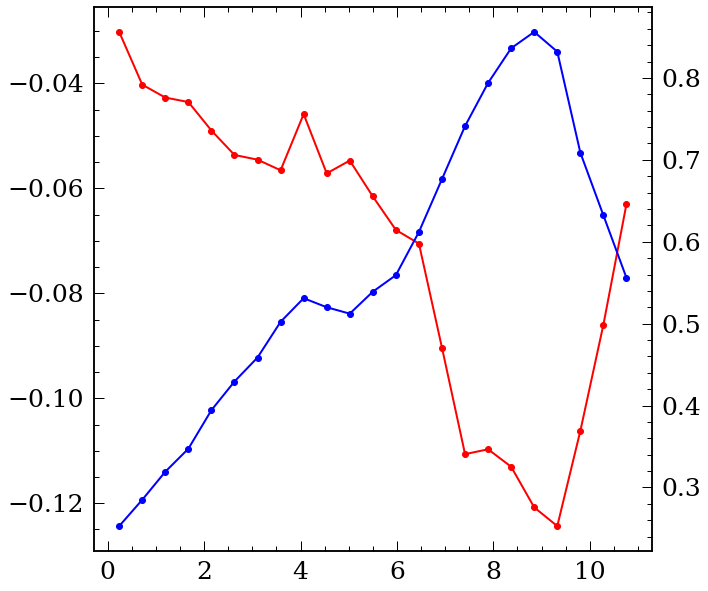

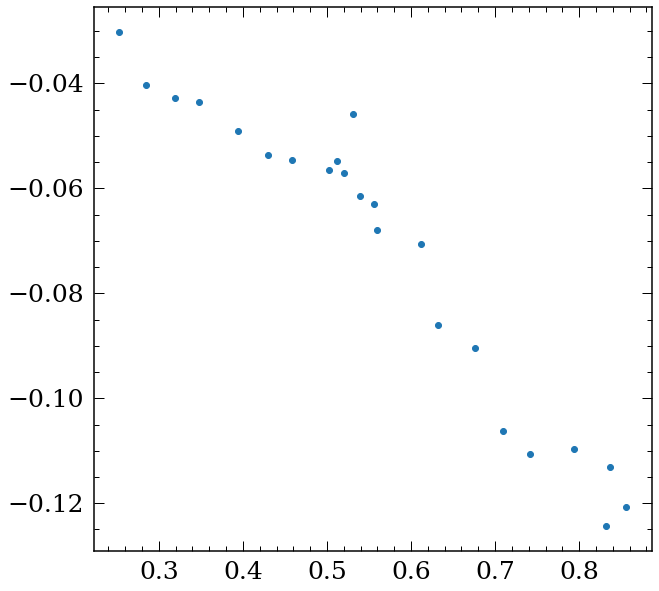

In [57]:
plt.plot(ages, slopes_rbir, 'r-o')
plt.twinx()
plt.plot(ages, fehscatter, 'b-o')

plt.figure()
plt.plot(fehscatter, slopes_rbir, 'o')


p = fitpoints(fehscatter, slopes_rbir)
print(np.mean(abs((slopes_rbir-p(fehscatter))/slopes_rbir)))




In [14]:
data['oh'] = data['ofe']+data['feh']

100%|██████████| 14/14 [00:21<00:00,  1.54s/it]


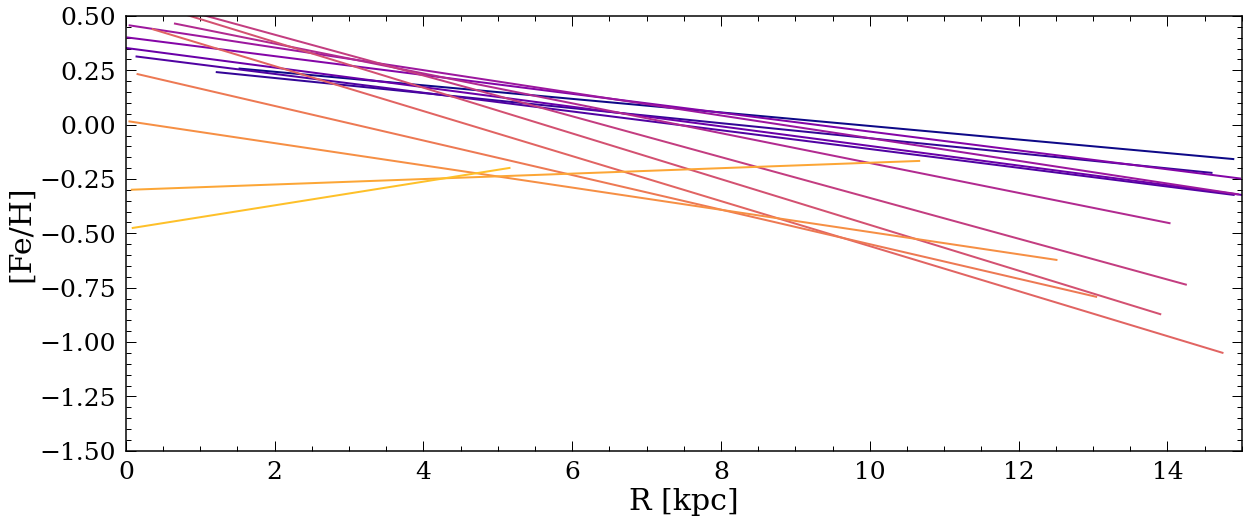

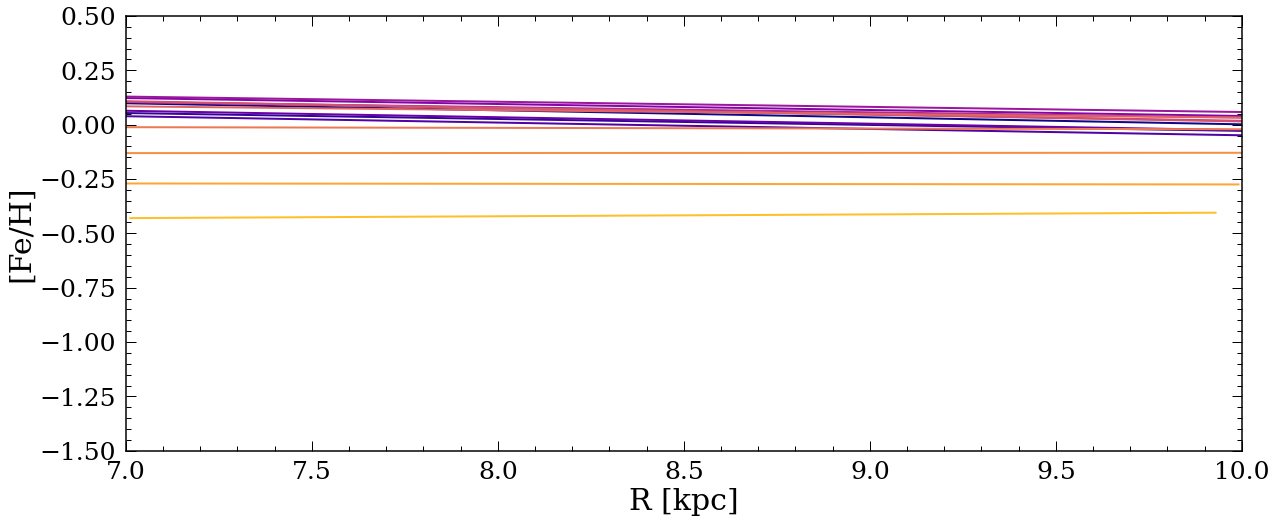

In [15]:



m = (data['R']>7)&(data['R']<10)
m = m&(data['feh']>-1)
#m = m&(data['hi_low']==0)

data_calc = data[m].reset_index(drop=True)

age_calc = np.linspace(0,14,15)
slopes_arr = np.zeros((len(age_calc)-1, 100))
fehscatter_arr = np.zeros((len(age_calc)-1, 100))

ages, slopes_rbir, fehscatter_rbir = monoage_line(data['oh'].values[m], 
                                        data['R_bir'].values[m], 
                                        data['age_new'].values[m],
                                        agebin=np.linspace(0,14,15),
                                        xlims=[0,15],plotlegend=False)

data_calc['age_new'] = [np.random.normal(i, 0.5) for i in data_calc['age']]
data_calc['R_new'] = [np.random.normal(i, 0.31) for i in data_calc['R']]
data_calc['oh_new'] = [np.random.normal(i, 0.03) for i in data_calc['oh']]
ages, slopes, fehscatter = monoage_line_range(data_calc['oh_new'].values, 
                                        data_calc['R_new'].values, 
                                        data_calc['age_new'].values,
                                        agebin=np.linspace(0,14,15),
                                        xlims=[7,10],plotlegend=False)





In [17]:
"""data_calc['ofe_new'] = [np.random.normal(i, 0.03) for i in data_calc['oh']]
ages, slopes, fehscatter = monoage_line_range(data_calc['ofe_new'].values, 
                                        data_calc['R_new'].values, 
                                        data_calc['age_new'].values,
                                        agebin=np.linspace(0,14,15),
                                        xlims=[7,10],plotlegend=False)"""

pd.DataFrame(np.array((ages, slopes, fehscatter, slopes_rbir, fehscatter_rbir)).T,
            columns=['age', 'slopes', 'fehscatter', 'slopes_rbir', 
                     'fehscatter_rbir']).to_csv('g2.79e12_ohscatter_simdata.csv', 
                                                index=False)





In [39]:
ismslope = pd.read_pickle('../NIHAORbirth/ISM_slope_g279e12.pkl')
m2pattern = pd.read_pickle('ISM_slope_g279e12.pkl')
merger = pd.read_pickle('./g2.79e12_merger_Lucy.dat')

mergertimes = 13.8-merger['time']
mergervir = merger['vir_ratio']

agebin=np.linspace(0,14,50)
mass_ave = np.zeros(len(agebin)-1)

agebin=np.linspace(0,14,50)
for i in range(len(agebin)-1):
    m = (mergertimes>agebin[i])&(mergertimes<agebin[i+1])
    #mass_ave[i] = sum(mergervir[m])
    if sum(m) == 0:
        mass_ave[i] = 0
    else:
        mass_ave[i] = sum(mergervir[m])/sum(m)

10


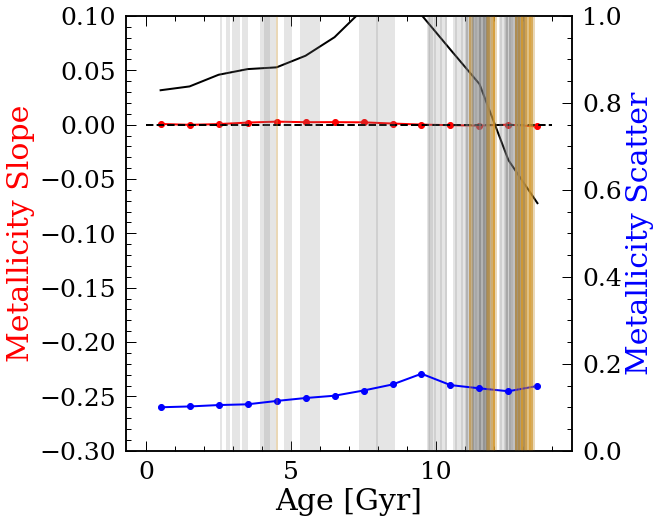

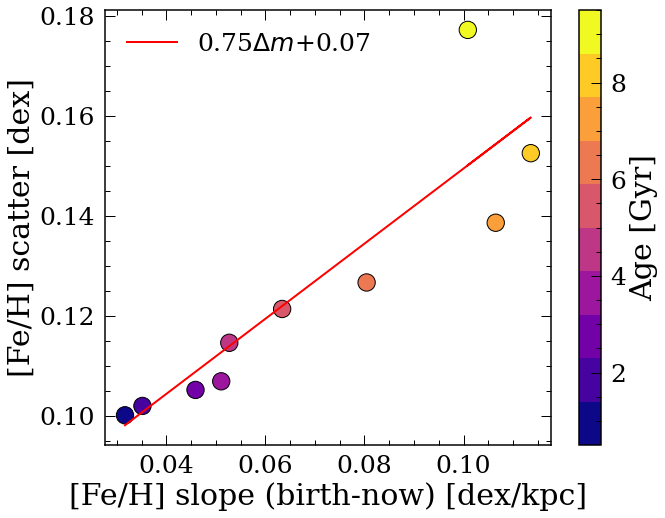

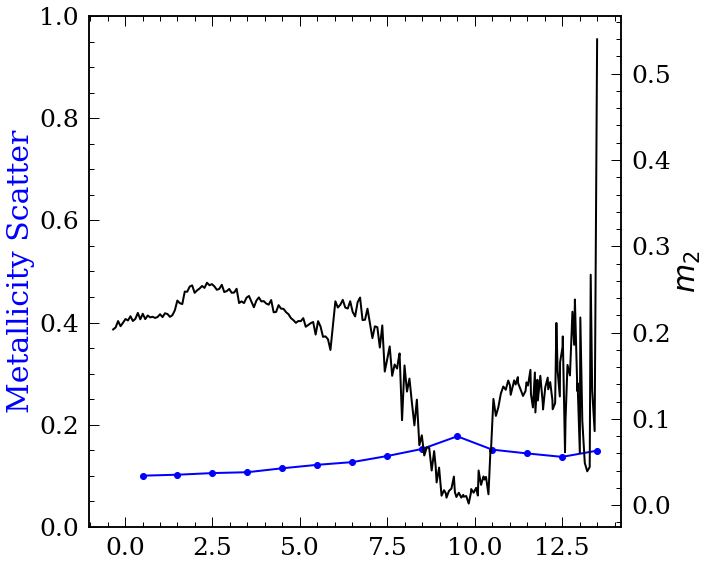

In [40]:
plt.figure(figsize=(8,8))
plt.plot(ages, slopes, 'r-o')
plt.plot(ages, slopes_rbir, 'k-',zorder=5)
plt.xlabel('Age [Gyr]')
plt.ylabel('Metallicity Slope', color='r',zorder=5)
plt.plot([0,14],[0,0], 'k--',zorder=5)
plt.ylim([-0.3, 0.1])

plt.twinx()
plt.plot(ages, fehscatter, 'b-o')
m = mergervir>0.1
plt.vlines(mergertimes, ymin=0, ymax=1, color='grey', alpha=0.2, zorder=1)
plt.vlines(mergertimes[m], ymin=0, ymax=1, color='orange', alpha=0.2, zorder=2)
plt.ylim([0,1])
plt.ylabel('Metallicity Scatter', color='b',zorder=5)

df = pd.DataFrame(np.array((ages, slopes, fehscatter, slopes_rbir, fehscatter_rbir)).T,
            columns=['age', 'slopes', 'fehscatter', 'slopes_rbir', 
                     'fehscatter_rbir'])

"""plt.figure(figsize=(10,8))
m = df['age']<10
plt.scatter(abs(df['slopes_rbir']-df['slopes'])[m], df['fehscatter'][m]/(df['disksize_norm'][m]), 
           c=df['age'][m], s=100, edgecolor='k', cmap=plt.get_cmap('plasma', sum(m)))
plt.xlabel('([Fe/H] slope |now-birth| [dex/kpc])/disksize_norm')
plt.ylabel('[Fe/H] scatter [dex]')
plt.plot([0,0.15], [0,1.5], 'r-')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')"""


plt.figure(figsize=(10,8))
m = df['age']<10
print(sum(m))
plt.scatter((df['slopes_rbir'])[m], df['fehscatter'][m], 
           c=df['age'][m], s=300, edgecolor='k', 
            cmap=plt.get_cmap('plasma', sum(m)))
p = fitpoints((df['slopes_rbir']-df['slopes'])[m], df['fehscatter'][m])
plt.xlabel('[Fe/H] slope (birth-now) [dex/kpc]')
plt.ylabel('[Fe/H] scatter [dex]')
plt.plot((df['slopes_rbir'])[m], 
         p((df['slopes_rbir'])[m]), 'r-', 
         label="%.2f$Δm$+%.2f"%(p[1],p[0]))
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.legend()
#plt.xlim([-0.01,0.12])
#plt.ylim([0.06,0.3])


plt.figure(figsize=(10,8))
p = fitpoints(ages, fehscatter)
plt.plot(ages, fehscatter, 'b-o')
plt.ylabel('Metallicity Scatter', color='b',zorder=10)
plt.ylim([0,1])
plt.twinx()
plt.plot(13.8-m2pattern['time'], m2pattern['m2'], 'k-')
plt.ylabel('$m_2$', color='k')
plt.xlabel('Age [Gyr]')
plt.tight_layout()

#plt.figure(figsize=(10,8))
#plt.plot(fehscatter-p(ages), mass_ave, 'ko')

In [28]:
"""m = (data['R']>7)&(data['R']<10)
m = m&(data['hi_low']==0)
ages, slopes, fehscatter = monoage_line(data['ofe'].values[m], 
                                        data['R_new'].values[m], 
                                        data['age_new'].values[m],
                                        agebin=np.linspace(0,14,15),
                                        xlims=[7,10],plotlegend=False)

ages, slopes_rbir, fehscatter_rbir = monoage_line(data['ofe_new'].values[m], 
                                        data['R_bir'].values[m], 
                                        data['age_new'].values[m],
                                        agebin=np.linspace(0,14,15),
                                        xlims=[0,15],plotlegend=False)"""

"m = (data['R']>7)&(data['R']<10)\nm = m&(data['hi_low']==0)\nages, slopes, fehscatter = monoage_line(data['ofe'].values[m], \n                                        data['R_new'].values[m], \n                                        data['age_new'].values[m],\n                                        agebin=np.linspace(0,14,15),\n                                        xlims=[7,10],plotlegend=False)\n\nages, slopes_rbir, fehscatter_rbir = monoage_line(data['ofe_new'].values[m], \n                                        data['R_bir'].values[m], \n                                        data['age_new'].values[m],\n                                        agebin=np.linspace(0,14,15),\n                                        xlims=[0,15],plotlegend=False)"

10


TypeError: expected non-empty vector for x

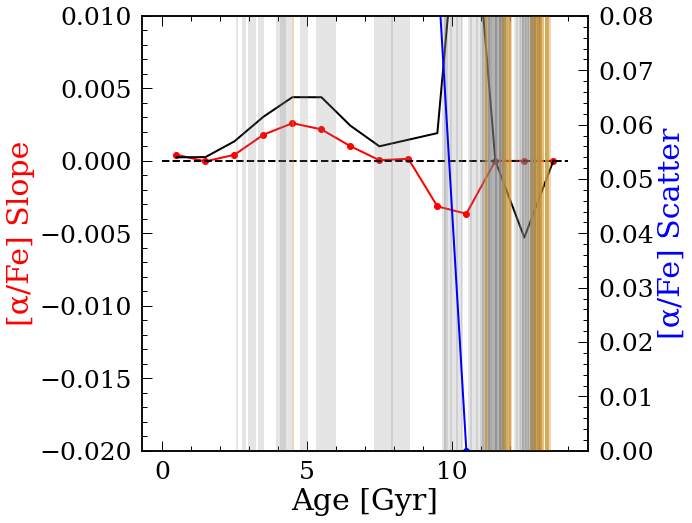

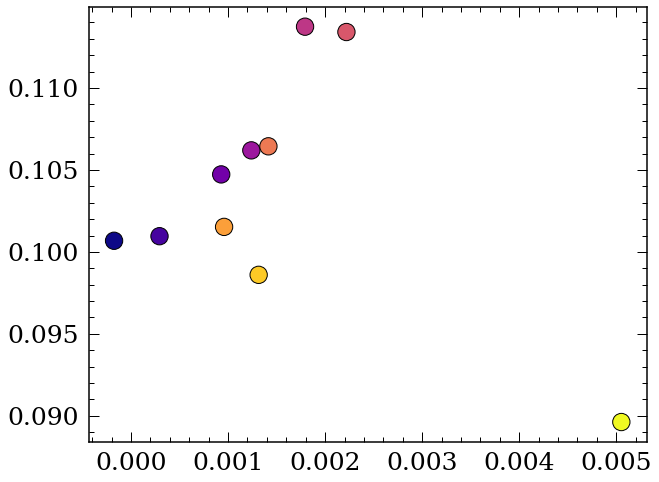

In [29]:
plt.figure(figsize=(8,8))
plt.plot(ages, slopes, 'r-o')
plt.plot(ages, slopes_rbir, 'k-',zorder=5)
plt.xlabel('Age [Gyr]')
plt.ylabel('[α/Fe] Slope', color='r',zorder=5)
plt.plot([0,14],[0,0], 'k--',zorder=5)
plt.ylim([-0.02, 0.01])

plt.twinx()
plt.plot(ages, fehscatter, 'b-o')
m = mergervir>0.1
plt.vlines(mergertimes, ymin=0, ymax=1, color='grey', alpha=0.2, zorder=1)
plt.vlines(mergertimes[m], ymin=0, ymax=1, color='orange', alpha=0.2, zorder=2)
plt.ylim([0,0.08])
plt.ylabel('[α/Fe] Scatter', color='b',zorder=5)


"""plt.figure(figsize=(10,8))
m = df['age']<10
plt.scatter(abs(df['slopes_rbir']-df['slopes'])[m], df['fehscatter'][m]/(df['disksize_norm'][m]), 
           c=df['age'][m], s=100, edgecolor='k', cmap=plt.get_cmap('plasma', sum(m)))
plt.xlabel('([Fe/H] slope |now-birth| [dex/kpc])/disksize_norm')
plt.ylabel('[Fe/H] scatter [dex]')
plt.plot([0,0.15], [0,1.5], 'r-')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
"""

df = pd.DataFrame(np.array((ages, slopes, fehscatter, slopes_rbir, fehscatter_rbir)).T,
            columns=['age', 'slopes', 'fehscatter', 'slopes_rbir', 
                     'fehscatter_rbir'])

plt.figure(figsize=(10,8))
m = df['age']<10

print(sum(m))
plt.scatter((df['slopes_rbir']-df['slopes'])[m], df['fehscatter'][m], 
           c=df['age'][m], s=300, edgecolor='k', 
            cmap=plt.get_cmap('plasma', sum(m)))

m = m&((df['slopes_rbir']-df['slopes'])<0.005)
m = m&(df['fehscatter']<0.04)

p = fitpoints((df['slopes_rbir']-df['slopes'])[m], df['fehscatter'][m])

plt.xlabel('[α/Fe] slope (birth-now) [dex/kpc]')
plt.ylabel('[α/Fe] scatter [dex]')
plt.plot((df['slopes_rbir']-df['slopes'])[m], 
         p((df['slopes_rbir']-df['slopes'])[m]), 'r-', 
         label="%.2f$Δm$+%.2f"%(p[1],p[0]))
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.legend()

plt.figure(figsize=(10,8))
p = fitpoints(ages, fehscatter)
plt.plot(ages, fehscatter, 'b-o')
plt.ylabel('[α/Fe] Scatter', color='b',zorder=10)
#plt.ylim([0,0.6])
plt.twinx()
plt.plot(13.8-m2pattern['time'], m2pattern['m2'], 'k-')
plt.ylabel('$m_2$', color='k')
plt.xlabel('Age [Gyr]')
plt.tight_layout()

#plt.figure(figsize=(10,8))
#plt.plot(fehscatter-p(ages), mass_ave, 'ko')

In [876]:
df = pd.DataFrame(np.array((ages, slopes, fehscatter, slopes_rbir, fehscatter_rbir)).T,
            columns=['age', 'slopes', 'fehscatter', 'slopes_rbir', 
                     'fehscatter_rbir'])
pd.DataFrame(np.array((ages, slopes, fehscatter, slopes_rbir, fehscatter_rbir)).T,
            columns=['age', 'slopes', 'fehscatter', 'slopes_rbir', 
                     'fehscatter_rbir']).to_csv('g2.79e12_ofescatter_simdata.csv', 
                                                index=False)




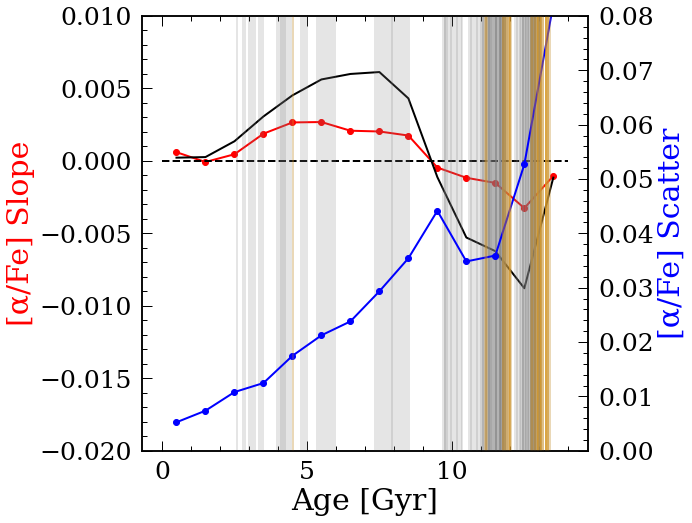

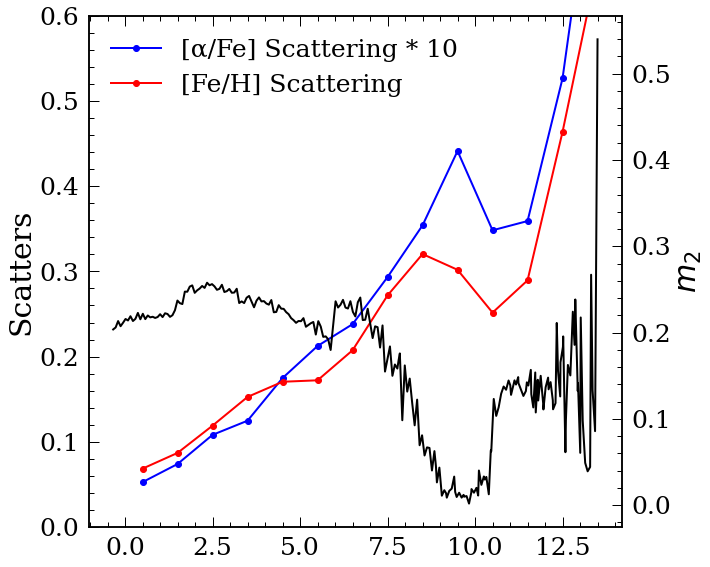

In [877]:
plt.figure(figsize=(8,8))
plt.plot(ages, slopes, 'r-o')
plt.plot(ages, slopes_rbir, 'k-',zorder=5)
plt.xlabel('Age [Gyr]')
plt.ylabel('[α/Fe] Slope', color='r',zorder=5)
plt.plot([0,14],[0,0], 'k--',zorder=5)
plt.ylim([-0.02, 0.01])

plt.twinx()
plt.plot(ages, fehscatter, 'b-o')
m = mergervir>0.1
plt.vlines(mergertimes, ymin=0, ymax=1, color='grey', alpha=0.2, zorder=1)
plt.vlines(mergertimes[m], ymin=0, ymax=1, color='orange', alpha=0.2, zorder=2)
plt.ylim([0,0.08])
plt.ylabel('[α/Fe] Scatter', color='b',zorder=5)

df = pd.read_csv('g2.79e12_fehscatter_simdata.csv')
df_ofe = pd.read_csv('g2.79e12_ofescatter_simdata.csv')

plt.figure(figsize=(10,8))
#p = fitpoints(ages, fehscatter)
plt.plot(df_ofe['age'], df_ofe['fehscatter']*10, 'b-o', label='[α/Fe] Scattering * 10')
plt.plot(df['age'], df['fehscatter'], 'r-o', label='[Fe/H] Scattering')
plt.ylabel('Scatters',zorder=10)
plt.ylim([0,0.6])
plt.legend(loc=2)
plt.twinx()
plt.plot(13.8-m2pattern['time'], m2pattern['m2'], 'k-')
plt.ylabel('$m_2$', color='k')
plt.xlabel('Age [Gyr]')
plt.tight_layout()

#plt.figure(figsize=(10,8))
#plt.plot(fehscatter-p(ages), mass_ave, 'ko')